Problem Statement:

In the manufacturing domain, particularly for perishable goods (food,electrical goods, pharmaceuticals, chemicals, etc.), product spoilage due to expiration is a significant challenge.

This leads to:

1. Financial Losses:
Waste of raw materials, production costs, and unsold inventory.
Supply Chain Inefficiencies: Suboptimal inventory rotation, urgent last-minute sales, or costly disposal.
Environmental Impact: Increased waste contributing to landfills.

2. Reputational Damage:
Delivering expired or near-expired products to customers.Current methods for determining shelf life often rely on fixed dates or limited studies. This project aims to introduce a data-driven approach using predictive analytics to forecast the remaining shelf life of products more accurately.

Project Goals:
1. Minimize Spoilage: Reduce the amount of expired or unsellable product.
2. Optimize Inventory Management: Enable "first-expire, first-out" (FEFO) strategies and dynamic inventory rotation.
3. Enhance Product Usability: Ensure products reach consumers with sufficient remaining shelf life.
4. Improve Production Planning: Provide insights for future production schedules based on shelf life trends.
5. Reduce Operational Costs: Lower waste disposal and inventory holding costs.

Project Title: Predictive Shelf Life Analytics (Manufacturing domain)

Project description: Predictive shelf life analytics forecasts the remaining shelf life of products based on historical data and environmental factors. It helps organizations anticipate potential shelf life issues and optimize inventory management to minimize spoilage and maximize product usability.

Data Science Steps:   

Phase 1: Foundation & Data Preparation

Problem Definition: Clearly define shelf life (technical/commercial expiry) and the remaining_shelf_life_days target. Set clear success metrics like reduced spoilage and improved inventory turnover.

Data Acquisition: Gather data from ERP, LIMS, IoT sensors (real-time), customer feedback, and integrate the pre-generated synthetic data.

Data Cleaning & Pre-processing: Cleanse data by handling missing values and outliers. Ensure consistent formats and align time-series data for all batches.

Phase 2: Feature Engineering & Modeling

Exploratory Data Analysis (EDA): Analyze combined real and synthetic data to understand distributions, correlations, and degradation patterns over time. Formulate hypotheses about key drivers.

Feature Engineering: Create powerful predictors. This includes time-since-manufacture, environmental aggregations (e.g., average, max, std dev of temperature/humidity from profiles), cumulative exposure, and rate of change features.

Model Selection & Training: Choose appropriate regression models (e.g., XGBoost, Random Forest) or survival analysis models. Split data, train the model, and hyperparameter tune for optimal performance.

Phase 3: Evaluation, Deployment & Monitoring

Model Evaluation: Assess model accuracy using metrics like MAE, RMSE, R-squared. Perform cross-validation and analyze feature importance. Get domain expert feedback for validation.

Model Deployment: Develop a scalable RESTful API for real-time predictions. Containerize the model and deploy it to a production environment.

Monitoring & Maintenance: Continuously track model performance. Implement data drift and concept drift detection. Set up automated retraining and alerting systems.

Reporting & Visualization: Build interactive dashboards to visualize predicted shelf life and at-risk batches. Generate automated reports to deliver clear, actionable insights for operations.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta

In [ ]:
import pandas as pd

# data created by Sayed
df = pd.read_csv("/content/predictive_shelf_life_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/predictive_shelf_life_data.csv'

In [ ]:
df.head()

In [ ]:
# Sample data -- Abhishek Akkewar


NUM_SAMPLES = 10000  # Reduced for faster execution with detailed profiles
PRODUCT_TYPES = ['LED_Bulb', 'Sensor_Module', 'Circuit_Board', 'Battery_Pack']
STORAGE_TYPES = ['Room_Temp', 'Cold_Storage', 'Humidity_Controlled']

# Helper functions
def generate_manufacture_date():
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2025, 1, 1)
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    return start_date + timedelta(days=random_days)

def simulate_environment_profile(duration_days, storage_type):
    temp_profile = []
    humidity_profile = []

    if storage_type == 'Room_Temp':
        base_temp = np.random.normal(25, 3) # Warmer, more fluctuation
        base_humidity = np.random.normal(65, 8)
    elif storage_type == 'Cold_Storage':
        base_temp = np.random.normal(5, 1.5) # Colder, less fluctuation
        base_humidity = np.random.normal(50, 5)
    elif storage_type == 'Humidity_Controlled':
        base_temp = np.random.normal(22, 2) # Stable temp
        base_humidity = np.random.normal(45, 3) # Stable humidity

    for _ in range(duration_days):
        temp = max(0, min(40, np.random.normal(base_temp, 2))) # Add daily fluctuation
        humidity = max(20, min(90, np.random.normal(base_humidity, 5))) # Add daily fluctuation
        temp_profile.append(round(temp, 2))
        humidity_profile.append(round(humidity, 2))
    return temp_profile, humidity_profile

def calculate_actual_shelf_life_with_profile(base_shelf_life, temp_profile, humidity_profile):
    current_degradation = 0
    actual_shelf_life_days = base_shelf_life # Start with base shelf life

    # Simulate daily degradation based on environmental profile
    for i in range(len(temp_profile)):
        temp = temp_profile[i]
        humidity = humidity_profile[i]

        # Degradation rules (can be more complex, e.g., non-linear, thresholds)
        daily_temp_penalty = max(0, (temp - 25)) * 0.8
        daily_humidity_penalty = max(0, (humidity - 60)) * 0.3

        current_degradation += daily_temp_penalty + daily_humidity_penalty

        # If cumulative degradation significantly impacts shelf life, potentially 'spoil' early
        # This is a simplified way to simulate early spoilage due to harsh conditions
        # In a real model, you'd track a quality metric that crosses a threshold
        if current_degradation > (base_shelf_life * 0.5) and i < base_shelf_life * 0.7:
             # If degradation is high and it's still early in life, reduce remaining life faster
             actual_shelf_life_days -= (daily_temp_penalty + daily_humidity_penalty) * 0.5 # Accelerate reduction
        elif current_degradation > base_shelf_life:
             # Product is effectively spoiled if degradation exceeds base shelf life "potential"
             actual_shelf_life_days = max(1, i + 1) # Set to current day + 1 to mark spoilage
             break # Product spoiled, no need to simulate further

    # Add some random noise to the final actual shelf life
    final_actual_shelf_life = max(1, base_shelf_life - current_degradation + np.random.normal(0, 5))
    return round(final_actual_shelf_life, 2)

# Main data generation
data = []
for i in range(NUM_SAMPLES):
    product_id = f"P{random.randint(1000, 9999)}"
    batch_id = f"BATCH_{random.randint(10000, 99999)}"
    product_type = random.choice(PRODUCT_TYPES)
    storage_type = random.choice(STORAGE_TYPES)
    manufacture_date = generate_manufacture_date()

    base_shelf_life = random.choice([180, 270, 365]) # Base shelf life in days

    # Simulate the full duration of the potential shelf life for environmental profile
    # Let's simulate up to 1.2 times the base shelf life to capture full degradation cycle
    simulated_duration = int(base_shelf_life * 1.2)
    temp_profile, humidity_profile = simulate_environment_profile(simulated_duration, storage_type)

    # Calculate actual shelf life based on the simulated profiles
    actual_shelf_life = calculate_actual_shelf_life_with_profile(base_shelf_life, temp_profile, humidity_profile)

    expiry_date = manufacture_date + timedelta(days=int(actual_shelf_life))

    # Inspection date should be within the product's actual life cycle
    # If actual_shelf_life is very low (e.g., 1 day), ensure inspection_date makes sense.
    inspection_days_offset = random.randint(1, max(1, int(actual_shelf_life)))
    inspection_date = manufacture_date + timedelta(days=inspection_days_offset)

    # Aggregate average temp/humidity from profile for the inspection period
    # This represents the average conditions *up to the inspection date*
    avg_temp_at_inspection = round(np.mean(temp_profile[:inspection_days_offset]), 2)
    avg_humidity_at_inspection = round(np.mean(humidity_profile[:inspection_days_offset]), 2)


    data.append({
        "product_id": product_id,
        "batch_id": batch_id,
        "product_type": product_type,
        "manufacture_date": manufacture_date.date(),
        "storage_type": storage_type,
        "base_shelf_life_days": base_shelf_life,
        # Real-time profiles (can be stored as strings or arrays in a database)
        "temperature_profile": temp_profile, # List of daily temps
        "humidity_profile": humidity_profile, # List of daily humidities
        # Aggregated features up to inspection
        "avg_temperature_at_inspection": avg_temp_at_inspection,
        "avg_humidity_at_inspection": avg_humidity_at_inspection,
        "actual_shelf_life_days": actual_shelf_life,
        "expiry_date": expiry_date.date(),
        "inspection_date": inspection_date.date(),
        "days_until_expiry_at_inspection": max(0, (expiry_date - inspection_date).days)
    })

# Convert to DataFrame
df = pd.DataFrame(data)

print("Synthetic data generated")
df.head()

In [ ]:
df.columns

| Column Name                       | Description                                                                      |
| --------------------------------- | -------------------------------------------------------------------------------- |
| `product_id`                      | Unique identifier for each individual product.                                   |
| `batch_id`                        | Identifier representing the manufacturing batch the product belongs to.          |
| `product_type`                    | Type/category of the product (e.g., LED\_Bulb, Battery\_Pack).                   |
| `manufacture_date`                | Date when the product was manufactured.                                          |
| `storage_type`                    | Type of storage environment used (e.g., Room\_Temp, Cold\_Storage).              |
| `base_shelf_life_days`            | Expected shelf life in ideal conditions, in days.                                |
| `temperature_profile`             | List of daily temperature readings during storage (time-series).                 |
| `humidity_profile`                | List of daily humidity readings during storage (time-series).                    |
| `avg_temperature_at_inspection`   | Average temperature experienced by the product up to the inspection date.        |
| `avg_humidity_at_inspection`      | Average humidity experienced by the product up to the inspection date.           |
| `actual_shelf_life_days`          | Real shelf life based on environmental degradation (used to derive expiry date). |
| `expiry_date`                     | Calculated date when the product is expected to expire.                          |
| `inspection_date`                 | Date on which product quality or condition was inspected.                        |
| `days_until_expiry_at_inspection` | **Target variable**: Number of days left until expiry from the inspection date.  |


In [ ]:
df.shape

# EDA

In [ ]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

In [ ]:
# Missing values
print("\nMissing Values:\n", df.isnull().sum())


In [ ]:
# Summary statistics
df.describe()


In [ ]:
# Categorical Feature Distribution

# Product types
sns.countplot(x='product_type', data=df)
plt.title("Product Type Distribution")
plt.xticks(rotation=45)
plt.show()

# Storage types
sns.countplot(x='storage_type', data=df)
plt.title("Storage Type Distribution")
plt.show()


In [ ]:
# Date ranges
print("Manufacture Date Range:", df['manufacture_date'].min(), "to", df['manufacture_date'].max())
print("Expiry Date Range:", df['expiry_date'].min(), "to", df['expiry_date'].max())


In [ ]:
sns.histplot(df['days_until_expiry_at_inspection'], kde=True, bins=30)
plt.title("Distribution of Days Until Expiry at Inspection")
plt.xlabel("Days Left")
plt.ylabel("Count")
plt.show()


In [ ]:
# Feature Relationships with Target
# Boxplots
plt.figure(figsize=(12, 5))
sns.boxplot(x='product_type', y='days_until_expiry_at_inspection', data=df)
plt.title("Days Until Expiry by Product Type")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='storage_type', y='days_until_expiry_at_inspection', data=df)
plt.title("Days Until Expiry by Storage Type")
plt.show()


In [ ]:
# Correlation Matrix (Numerical Features)

# Convert dates to numerical format for correlation
df['manufacture_date_num'] = pd.to_datetime(df['manufacture_date']).astype(int) / 10**9
df['inspection_date_num'] = pd.to_datetime(df['inspection_date']).astype(int) / 10**9
df['expiry_date_num'] = pd.to_datetime(df['expiry_date']).astype(int) / 10**9

# Select only numerical columns
num_cols = ['base_shelf_life_days', 'avg_temperature_at_inspection', 'avg_humidity_at_inspection',
            'actual_shelf_life_days', 'days_until_expiry_at_inspection',
            'manufacture_date_num', 'inspection_date_num', 'expiry_date_num']

corr = df[num_cols].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
sns.violinplot(x='storage_type', y='avg_temperature_at_inspection', data=df)
plt.title("Temperature Distribution by Storage Type")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Constants
NUM_SAMPLES = 10000
PRODUCT_TYPES = ['LED_Bulb', 'Sensor_Module', 'Circuit_Board', 'Battery_Pack']
STORAGE_TYPES = ['Room_Temp', 'Cold_Storage', 'Humidity_Controlled']

# Helper functions
def generate_manufacture_date():
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2025, 1, 1)
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    return start_date + timedelta(days=random_days)

def simulate_environment_profile(duration_days, storage_type):
    temp_profile = []
    humidity_profile = []
    if storage_type == 'Room_Temp':
        base_temp = np.random.normal(25, 3)
        base_humidity = np.random.normal(65, 8)
    elif storage_type == 'Cold_Storage':
        base_temp = np.random.normal(5, 1.5)
        base_humidity = np.random.normal(50, 5)
    elif storage_type == 'Humidity_Controlled':
        base_temp = np.random.normal(22, 2)
        base_humidity = np.random.normal(45, 3)
    for _ in range(duration_days):
        temp = max(0, min(40, np.random.normal(base_temp, 2)))
        humidity = max(20, min(90, np.random.normal(base_humidity, 5)))
        temp_profile.append(round(temp, 2))
        humidity_profile.append(round(humidity, 2))
    return temp_profile, humidity_profile

def calculate_actual_shelf_life_with_profile(base_shelf_life, temp_profile, humidity_profile):
    current_degradation = 0
    actual_shelf_life_days = base_shelf_life
    for i in range(len(temp_profile)):
        temp = temp_profile[i]
        humidity = humidity_profile[i]
        daily_temp_penalty = max(0, (temp - 25)) * 0.8
        daily_humidity_penalty = max(0, (humidity - 60)) * 0.3
        current_degradation += daily_temp_penalty + daily_humidity_penalty
        if current_degradation > (base_shelf_life * 0.5) and i < base_shelf_life * 0.7:
            actual_shelf_life_days -= (daily_temp_penalty + daily_humidity_penalty) * 0.5
        elif current_degradation > base_shelf_life:
            actual_shelf_life_days = max(1, i + 1)
            break
    final_actual_shelf_life = max(1, base_shelf_life - current_degradation + np.random.normal(0, 5))
    return round(final_actual_shelf_life, 2)

# Main data generation
data = []
for i in range(NUM_SAMPLES):
    product_id = f"P{random.randint(1000, 9999)}"
    batch_id = f"BATCH_{random.randint(10000, 99999)}"
    product_type = random.choice(PRODUCT_TYPES)
    storage_type = random.choice(STORAGE_TYPES)
    manufacture_date = generate_manufacture_date()
    base_shelf_life = random.choice([180, 270, 365])
    simulated_duration = int(base_shelf_life * 1.2)
    temp_profile, humidity_profile = simulate_environment_profile(simulated_duration, storage_type)
    actual_shelf_life = calculate_actual_shelf_life_with_profile(base_shelf_life, temp_profile, humidity_profile)
    expiry_date = manufacture_date + timedelta(days=int(actual_shelf_life))
    inspection_days_offset = random.randint(1, max(1, int(actual_shelf_life)))
    inspection_date = manufacture_date + timedelta(days=inspection_days_offset)
    avg_temp_at_inspection = round(np.mean(temp_profile[:inspection_days_offset]), 2)
    avg_humidity_at_inspection = round(np.mean(humidity_profile[:inspection_days_offset]), 2)
    temperature_variance_at_inspection = round(np.std(temp_profile[:inspection_days_offset]), 2)
    humidity_variance_at_inspection = round(np.std(humidity_profile[:inspection_days_offset]), 2)
    high_temp_days = sum(t > 30 for t in temp_profile[:inspection_days_offset])
    high_humidity_days = sum(h > 70 for h in humidity_profile[:inspection_days_offset])
    avg_temp_last_7_days = round(np.mean(temp_profile[max(0, inspection_days_offset-7):inspection_days_offset]), 2)
    avg_humidity_last_7_days = round(np.mean(humidity_profile[max(0, inspection_days_offset-7):inspection_days_offset]), 2)
    storage_duration = inspection_days_offset
    storage_condition_score = round(avg_temp_at_inspection * 0.6 + avg_humidity_at_inspection * 0.4, 2)
    over_shelf_life_flag = int(inspection_days_offset > base_shelf_life)
    manufacture_month = manufacture_date.month
    inspection_month = inspection_date.month
    days_since_manufacture = inspection_days_offset
    days_in_transit = random.randint(1, 10)
    last_inspection_offset = random.randint(1, inspection_days_offset)
    days_since_last_inspection = inspection_days_offset - last_inspection_offset
    sensor_failure_flag = random.choices([0, 1], weights=[0.9, 0.1])[0]
    power_outage_events = random.randint(0, 2) if storage_type == 'Cold_Storage' else 0
    storage_utilization_pct = round(random.uniform(50, 100), 2)
    shift = random.choice(['Morning', 'Afternoon', 'Night'])
    is_holiday_season = 1 if manufacture_date.month in [11, 12, 1] else 0


    data.append({
        "product_id": product_id,
        "batch_id": batch_id,
        "product_type": product_type,
        "manufacture_date": manufacture_date.date(),
        "storage_type": storage_type,
        "base_shelf_life_days": base_shelf_life,
        "temperature_profile": temp_profile,
        "humidity_profile": humidity_profile,
        "avg_temperature_at_inspection": avg_temp_at_inspection,
        "avg_humidity_at_inspection": avg_humidity_at_inspection,
        "actual_shelf_life_days": actual_shelf_life,
        "expiry_date": expiry_date.date(),
        "inspection_date": inspection_date.date(),
        "days_until_expiry_at_inspection": max(0, (expiry_date - inspection_date).days),
        "temperature_variance_at_inspection": temperature_variance_at_inspection,
        "humidity_variance_at_inspection": humidity_variance_at_inspection,
        "high_temp_days": high_temp_days,
        "high_humidity_days": high_humidity_days,
        "avg_temp_last_7_days": avg_temp_last_7_days,
        "avg_humidity_last_7_days": avg_humidity_last_7_days,
        "storage_duration": storage_duration,
        "storage_condition_score": storage_condition_score,
        "over_shelf_life_flag": over_shelf_life_flag,
        "manufacture_month": manufacture_month,
        "inspection_month": inspection_month,
        "days_since_manufacture": days_since_manufacture,
        "days_in_transit": days_in_transit,
        "days_since_last_inspection": days_since_last_inspection,
        "sensor_failure_flag": sensor_failure_flag,
        "power_outage_events": power_outage_events,
        "storage_utilization_pct": storage_utilization_pct,
        "shift": shift,
        "is_holiday_season": is_holiday_season

    })

df = pd.DataFrame(data)
df.head()


| Feature Name                         | Description                                                       |
| ------------------------------------ | ----------------------------------------------------------------- |
| `product_id`                         | Unique identifier for each product instance.                      |
| `batch_id`                           | Unique identifier for a product batch.                            |
| `product_type`                       | Type of product (e.g., LED\_Bulb, Sensor\_Module).                |
| `manufacture_date`                   | Date the product was manufactured.                                |
| `storage_type`                       | Storage environment used (e.g., Room\_Temp, Cold\_Storage).       |
| `base_shelf_life_days`               | Ideal shelf life in days under optimal conditions.                |
| `temperature_profile`                | Daily temperature readings during storage.                        |
| `humidity_profile`                   | Daily humidity readings during storage.                           |
| `avg_temperature_at_inspection`      | Average temperature until inspection.                             |
| `avg_humidity_at_inspection`         | Average humidity until inspection.                                |
| `actual_shelf_life_days`             | ✅ **Regression Target**: Real shelf life impacted by conditions.  |
| `expiry_date`                        | Expected expiry based on actual shelf life.                       |
| `inspection_date`                    | Date when product was inspected.                                  |
| `days_until_expiry_at_inspection`    | Days remaining from inspection to expiry.                         |
| `temperature_variance_at_inspection` | Standard deviation of temp till inspection.                       |
| `humidity_variance_at_inspection`    | Standard deviation of humidity till inspection.                   |
| `high_temp_days`                     | Count of days with temperature > 30°C.                            |
| `high_humidity_days`                 | Count of days with humidity > 70%.                                |
| `avg_temp_last_7_days`               | Average temp in the last 7 days before inspection.                |
| `avg_humidity_last_7_days`           | Average humidity in the last 7 days before inspection.            |
| `storage_duration`                   | Days product was stored before inspection.                        |
| `storage_condition_score`            | Composite score combining temp and humidity at inspection.        |
| `over_shelf_life_flag`               | ✅ **Classification Target**: 1 if inspected post base shelf life. |
| `manufacture_month`                  | Month of manufacturing (1 to 12).                                 |
| `inspection_month`                   | Month when inspection occurred.                                   |
| `days_since_manufacture`             | Time gap between manufacture and inspection in days.              |
| `days_in_transit`                    | Estimated days the product spent in transit.                      |
| `days_since_last_inspection`         | Days since previous inspection.                                   |
| `sensor_failure_flag`                | Binary flag indicating sensor malfunction (1 = failed).           |
| `power_outage_events`                | Number of power outages during cold storage.                      |
| `storage_utilization_pct`            | Storage space utilization percentage (50–100%).                   |
| `shift`                              | Work shift when inspection occurred (Morning/Afternoon/Night).    |
| `is_holiday_season`                  | Binary flag: 1 if manufacture month is Nov-Jan.                   |


Modeling Targets

Regression: Predict actual_shelf_life_days

Classification: Predict over_shelf_life_flag or risk of early expiry

In [ ]:
df.columns

In [ ]:
print(df.shape)
print(df.dtypes)

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['actual_shelf_life_days'], bins=30, kde=True)
plt.title('Distribution of Actual Shelf Life Days')
plt.xlabel('Actual Shelf Life (days)')
plt.show()


In [ ]:
sns.countplot(x='over_shelf_life_flag', data=df)
plt.title('Over Shelf Life Flag Distribution')
plt.xlabel('Over Shelf Life (1 = Yes)')
plt.ylabel('Count')
plt.show()


In [ ]:
# Select numerical features
numeric_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
sns.scatterplot(x='storage_condition_score', y='actual_shelf_life_days', hue='storage_type', data=df)
plt.title('Storage Condition Score vs Actual Shelf Life')
plt.xlabel('Storage Condition Score')
plt.ylabel('Actual Shelf Life (days)')
plt.show()

# **Synthetic Data Creation Final**

In [ ]:
# Sample data -- Syed Ismail Khadry
# Updated for haveing more Correlation & also added additional Features

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap # Import the SHAP library
from sklearn.feature_selection import SelectKBest, f_regression

# Reproducibility
random.seed(42)
np.random.seed(42)

# Constants
NUM_SAMPLES = 10000
PRODUCT_TYPES = ['Capacitor', 'Memory_Chip', 'Laser_Diode', 'Battery_Pack']
STORAGE_TYPES = ['Room_Temp', 'Cold_Storage', 'Humidity_Controlled']

# Base realistic shelf life (in days) and their sensitivity factors
# Higher degradation_factor means more sensitive to environmental conditions
BASE_SHELF_INFO = {
    'Capacitor': {'base_days': random.choice([365*2, 365*3, 365*5]), 'temp_sensitivity': 0.04, 'hum_sensitivity': 0.02, 'variance_sensitivity': 0.015, 'power_outage_impact': 8}, # Very sensitive
    'Memory_Chip': {'base_days': 365*5, 'temp_sensitivity': 0.02, 'hum_sensitivity': 0.005, 'variance_sensitivity': 0.005, 'power_outage_impact': 3}, # Less sensitive
    'Laser_Diode': {'base_days': 365*5, 'temp_sensitivity': 0.025, 'hum_sensitivity': 0.008, 'variance_sensitivity': 0.008, 'power_outage_impact': 4}, # Moderately sensitive
    'Battery_Pack': {'base_days': random.choice([365*3, 365*5, 365*8]), 'temp_sensitivity': 0.035, 'hum_sensitivity': 0.01, 'variance_sensitivity': 0.01, 'power_outage_impact': 10} # Sensitive, especially to temp
}

# Ideal environmental conditions based on simulate_environment_profile
IDEAL_CONDITIONS = {
    'Room_Temp': {'temp': 25, 'hum': 50},
    'Cold_Storage': {'temp': 5, 'hum': 40},
    'Humidity_Controlled': {'temp': 22, 'hum': 45}
}


def generate_manufacture_date():
    # Use current year for more realistic date range in the future
    current_year = datetime.now().year
    start_date = datetime(current_year - 2, 1, 1) # e.g., Jan 2023
    end_date = datetime(current_year, 1, 1) # e.g., Jan 2025
    delta = end_date - start_date
    return start_date + timedelta(days=random.randint(0, delta.days))

def simulate_environment_profile(duration, storage_type):
    if storage_type == 'Room_Temp':
        base_temp, temp_std = 25, 3
        base_hum, hum_std = 50, 10
    elif storage_type == 'Cold_Storage':
        base_temp, temp_std = 5, 2
        base_hum, hum_std = 40, 5
    else:  # Humidity_Controlled
        base_temp, temp_std = 22, 2
        base_hum, hum_std = 45, 3

    # Simulate daily fluctuations over the given duration
    temp_profile = np.clip(np.random.normal(loc=base_temp, scale=temp_std, size=duration), 0, 45)
    hum_profile = np.clip(np.random.normal(loc=base_hum, scale=hum_std, size=duration), 10, 90)
    return temp_profile.tolist(), hum_profile.tolist()

def calculate_actual_shelf_life_with_profile(base_shelf_info, avg_temp_at_inspection, avg_hum_at_inspection,
                                             temp_variance_at_inspection, hum_variance_at_inspection,
                                             days_since_manufacture, power_outage_events):

    base_shelf = base_shelf_info['base_days']
    temp_sensitivity = base_shelf_info['temp_sensitivity']
    hum_sensitivity = base_shelf_info['hum_sensitivity']
    variance_sensitivity = base_shelf_info['variance_sensitivity']
    po_impact = base_shelf_info['power_outage_impact']

    # --- Degradation based on average conditions up to inspection ---
    # We assume degradation is cumulative and more pronounced for higher deviations

    # Temperature degradation: exponential decay for higher temps
    # Example: At 30C (5C above 25C), decay factor is (1 + 5 * 0.04) = 1.2
    # This means effective shelf life is base_shelf / 1.2
    temp_degradation_factor = 1 + max(0, avg_temp_at_inspection - 25) * temp_sensitivity

    # Humidity degradation
    hum_degradation_factor = 1 + max(0, avg_hum_at_inspection - 50) * hum_sensitivity

    # --- Degradation based on variance ---
    # High variance is bad. Let's make it more impactful for very sensitive products.
    variance_degradation_factor = 1 + (temp_variance_at_inspection + hum_variance_at_inspection) * variance_sensitivity

    # Combine degradation factors
    # A multiplier > 1 means the effective shelf life is shorter (base_shelf / multiplier)
    total_degradation_multiplier = temp_degradation_factor * hum_degradation_factor * variance_degradation_factor

    effective_shelf = base_shelf / total_degradation_multiplier


# --- IMPORTANT: Introduce random noise to make R2 < 1.00 ---
    # This simulates unobserved factors influencing actual shelf life
    # Adding noise relative to the base shelf life
    # For example, +/- 5% of base_shelf life
    effective_shelf += np.random.normal(0, base_shelf * 0.05)


    # --- Impact of power outages (linear reduction) ---
   # effective_shelf -= power_outage_events * po_impact  # Reduce effective shelf life by impact of power outages

    # Ensure actual shelf life doesn't go below a realistic minimum
    min_shelf_life = base_shelf * 0.3 # Allow for a more significant reduction but with a floor
    return max(effective_shelf, min_shelf_life)


# Generate records
records = []
for _ in range(NUM_SAMPLES):
    mfg = generate_manufacture_date()
    pt = random.choice(PRODUCT_TYPES)

    # Get base shelf life and sensitivities for the chosen product type
    product_info = BASE_SHELF_INFO[pt]
    base = product_info['base_days']

    # Simulate environment profile for a duration slightly longer than base shelf life
    # to ensure we have enough data for inspection at various points
    dur = int(base * 1.5) # Simulate for 150% of base shelf life
    st = random.choice(STORAGE_TYPES)
    tp, hp = simulate_environment_profile(dur, st)

    # Power outages are more likely in Room_Temp or less controlled environments
    power_out = np.random.poisson(1) if st in ['Room_Temp'] else np.random.poisson(0.1) # Less likely in cold/humidity controlled
    power_out = min(power_out, 3) # Cap power outages for realism

    # Inspection date logic
    # Inspection can happen before, at, or after the base shelf life
    # Ensure inspection date is not too far into the future (max 1 year from now)
    current_date_for_max_offset = datetime.now() # Use current time for more up-to-date calculation
    max_insp_offset = (current_date_for_max_offset - mfg).days + 365 # Up to 1 year from current date

    # Make inspection date more likely to be within the expected shelf life,
    # but still allow for some past-shelf-life inspections.
    # Let's target inspection within 1 to 1.5 * base shelf life, but capped by current date + 1 year
    insp_offset_target = random.randint(1, int(base * 1.5))
    insp_offset = min(insp_offset_target, max_insp_offset)
    insp_offset = max(1, insp_offset) # Ensure at least 1 day storage

    insp = mfg + timedelta(days=insp_offset)

    # Ensure profile data exists for the inspection duration
    tp_at_insp = tp[:insp_offset]
    hp_at_insp = hp[:insp_offset]

    # Calculate average and variance up to inspection
    avg_tp_ins = round(np.mean(tp_at_insp), 2) if tp_at_insp else np.mean(tp) # Fallback if insp_offset is 0
    avg_hp_ins = round(np.mean(hp_at_insp), 2) if hp_at_insp else np.mean(hp)
    var_tp_ins = round(np.std(tp_at_insp), 2) if tp_at_insp and len(tp_at_insp) > 1 else 0
    var_hp_ins = round(np.std(hp_at_insp), 2) if hp_at_insp and len(hp_at_insp) > 1 else 0

    # Calculate actual shelf life based on environmental conditions up to inspection
    actual = calculate_actual_shelf_life_with_profile(
        base_shelf_info=product_info,
        avg_temp_at_inspection=avg_tp_ins,
        avg_hum_at_inspection=avg_hp_ins,
        temp_variance_at_inspection=var_tp_ins,
        hum_variance_at_inspection=var_hp_ins,
        days_since_manufacture=insp_offset, # This isn't directly used in the function anymore for total shelf life, but useful for context
        power_outage_events=power_out
    )

    exp = mfg + timedelta(days=int(actual))

    # Additional derived metrics
    high_t = sum(t > 30 for t in tp_at_insp)
    high_h = sum(h > 70 for h in hp_at_insp)

    # Ensure 7-day average window is valid
    avg_t7 = round(np.mean(tp[max(0,insp_offset-7):insp_offset]),2) if len(tp) >= 7 else avg_tp_ins
    avg_h7 = round(np.mean(hp[max(0,insp_offset-7):insp_offset]),2) if len(hp) >= 7 else avg_hp_ins

    # Storage condition score: A weighted average, potentially inverse correlation with shelf life
    # Let's make it a score where lower is better
    stor_cond = round(avg_tp_ins * 0.4 + avg_hp_ins * 0.3 + (var_tp_ins + var_hp_ins) * 0.1 + high_t * 0.5 + high_h * 0.5, 2)

    over = int(insp_offset > actual) # Flag if inspection happened after calculated actual shelf life
    shift = random.choice(['Morning','Afternoon','Night'])

    # Introduce `days_since_last_inspection` realistically
    days_since_last_insp = 0
    # Simulate a history of inspections for a batch to get a realistic 'days_since_last_inspection'
    # For simplicity, let's assume a few inspection points if storage duration is long enough
    if insp_offset > 30: # If item has been stored for more than a month
        num_past_inspections = random.randint(0, 3) # Up to 3 previous inspections
        if num_past_inspections > 0:
            # Assume previous inspections were somewhat regularly spaced
            days_since_last_insp = random.randint(1, min(insp_offset, 180)) # Last inspection up to 6 months ago
        else:
            days_since_last_insp = insp_offset # This is the first inspection
    else:
        days_since_last_insp = insp_offset # If short storage, it's likely the first inspection


    rec = {
        "product_id": f"P{random.randint(1000,9999)}",
        "batch_id": f"BATCH_{random.randint(10000,99999)}",
        "product_type": pt,
        "manufacture_date": mfg.date(),
        "storage_type": st,
        "base_shelf_life_days": base,
        "temperature_profile": tp, # Full profile for potential future analysis
        "humidity_profile": hp, # Full profile
        "avg_temperature_at_inspection": avg_tp_ins,
        "avg_humidity_at_inspection": avg_hp_ins,
        "actual_shelf_life_days": round(actual,2),
        "expiry_date": exp.date(),
        "inspection_date": insp.date(),
        "days_until_expiry_at_inspection": max(0,(exp-insp).days),
        "temperature_variance_at_inspection": var_tp_ins,
        "humidity_variance_at_inspection": var_hp_ins,
        "high_temp_days": high_t,
        "high_humidity_days": high_h,
        "avg_temp_last_7_days": avg_t7,
        "avg_humidity_last_7_days": avg_h7,
        "storage_duration": insp_offset, # Renamed from days_since_manufacture for clarity
        "storage_condition_score": stor_cond,
        "over_shelf_life_flag": over,
        "manufacture_month": mfg.month,
        "inspection_month": insp.month,
        "days_since_manufacture": insp_offset, # Keep this for consistency, same as storage_duration
        "days_in_transit": random.randint(1,10),
        "days_since_last_inspection": days_since_last_insp,
        "sensor_failure_flag": random.choices([0,1],weights=[0.95,0.05])[0], # Reduced failure rate
        "power_outage_events": power_out,
        "storage_utilization_pct": round(random.uniform(50,100),2),
        "shift": shift,
        "is_holiday_season": int(mfg.month in [11,12,1])
    }
    records.append(rec)

# Create DataFrame
df = pd.DataFrame(records)

# --- Add the new features ---

# 1. Environmental Risk & Deviation Features
df['temp_deviation_from_ideal'] = df.apply(
    lambda row: abs(row['avg_temperature_at_inspection'] - IDEAL_CONDITIONS[row['storage_type']]['temp']), axis=1
)
df['humidity_deviation_from_ideal'] = df.apply(
    lambda row: abs(row['avg_humidity_at_inspection'] - IDEAL_CONDITIONS[row['storage_type']]['hum']), axis=1
)
df['temp_humidity_stress_score'] = (df['temp_deviation_from_ideal'] * 0.6) + \
                                   (df['humidity_deviation_from_ideal'] * 0.4)
df['temp_humidity_volatility_score'] = df['temperature_variance_at_inspection'] + \
                                      df['humidity_variance_at_inspection']

# 2. Time-Derived Features
# Handle potential division by zero for actual_shelf_life_days if it's 0 or very small
df['days_until_expiry_ratio'] = df.apply(
    lambda row: row['days_until_expiry_at_inspection'] / row['actual_shelf_life_days'] if row['actual_shelf_life_days'] > 0 else 0,
    axis=1
)

df['is_mid_shelf_life'] = ((df['days_since_manufacture'] >= 0.25 * df['actual_shelf_life_days']) &
                           (df['days_since_manufacture'] <= 0.75 * df['actual_shelf_life_days'])).astype(int)
# inspection_lag_after_last is already days_since_last_inspection
df['inspection_lag_after_last'] = df['days_since_last_inspection']

# Ensure storage_duration is not zero for days_in_transit_ratio
df['days_in_transit_ratio'] = df.apply(
    lambda row: row['days_in_transit'] / row['storage_duration'] if row['storage_duration'] > 0 else 0,
    axis=1
)


# 3. Categorical Encoding or Grouping
df['product_storage_combo'] = df['product_type'] + "_" + df['storage_type']
shift_mapping = {'Morning': 0, 'Afternoon': 1, 'Night': 2}
df['shift_numeric'] = df['shift'].map(shift_mapping)
df['is_cold_chain_risk'] = ((df['storage_type'] == 'Cold_Storage') &
                            ((df['sensor_failure_flag'] == 1) | (df['power_outage_events'] > 0))).astype(int)

# 4. Statistical or Historical Aggregates
df['batch_mean_utilization'] = df.groupby('batch_id')['storage_utilization_pct'].transform('mean')
df['product_type_avg_shelf_life'] = df.groupby('product_type')['actual_shelf_life_days'].transform('mean')
df['is_above_product_avg_life'] = (df['actual_shelf_life_days'] > df['product_type_avg_shelf_life']).astype(int)


df.head()


product_id     batch_id product_type manufacture_date         storage_type  \
0      P9935  BATCH_21395  Laser_Diode       2023-01-26            Room_Temp   
1      P9928  BATCH_64987  Memory_Chip       2023-08-12  Humidity_Controlled   
2      P4527  BATCH_54118  Memory_Chip       2023-01-07  Humidity_Controlled   
3      P7201  BATCH_20328  Laser_Diode       2023-12-19            Room_Temp   
4      P2307  BATCH_40512  Memory_Chip       2024-01-06  Humidity_Controlled   

   base_shelf_life_days                                temperature_profile  \
0                  1825  [26.4901424590337, 24.585207096486446, 26.9430...   
1                  1825  [25.27347992366128, 21.633398580947606, 21.960...   
2                  1825  [24.065992158192778, 19.24766596716413, 21.517...   
3                  1825  [20.403334638279066, 24.190778180165026, 25.75...   
4                  1825  [20.35882940829211, 18.426021980378415, 23.557...   

                                    humidity_profile  \
0  [53.423378344896214, 65.54160420714774, 58.539...   
1  [42.6388911632001, 42.065203052201284, 43.4800...   
2  [44.60914125214825, 47.31079958544931, 42.5869...   
3  [51.74515661545795, 46.476951266508294, 50.629...   
4  [44.39754829637505, 46.181856026981805, 42.410...   

   avg_temperature_at_inspection  avg_humidity_at_inspection  ...  \
0                          25.07                       49.86  ...   
1                          21.93                       45.07  ...   
2                          22.01                       45.02  ...   
3                          25.18                       50.21  ...   
4                          21.88                       44.82  ...   

   days_until_expiry_ratio is_mid_shelf_life inspection_lag_after_last  \
0                 0.439257                 1                       915   
1                 0.468206                 1                       167   
2                 0.286182                 1                        40   
3                 0.471494                 1                       926   
4                 0.839874                 0                        75   

   days_in_transit_ratio            product_storage_combo  shift_numeric  \
0               0.010929            Laser_Diode_Room_Temp              0   
1               0.003791  Memory_Chip_Humidity_Controlled              0   
2               0.001572  Memory_Chip_Humidity_Controlled              1   
3               0.009719            Laser_Diode_Room_Temp              2   
4               0.007018  Memory_Chip_Humidity_Controlled              0   

   is_cold_chain_risk  batch_mean_utilization  product_type_avg_shelf_life  \
0                   0                   51.49                  1707.372476   
1                   0                   63.91                  1751.536358   
2                   0                   54.84                  1751.536358   
3                   0                   81.43                  1707.372476   
4                   0                   72.67                  1751.536358   

   is_above_product_avg_life  
0                          0  
1                          1  
2                          1  
3                          1  
4                          1  

[5 rows x 47 columns]

In [ ]:
excel_filename = "synthetic_data_New_Feature.xlsx"
df.to_excel(excel_filename, index=False)
from google.colab import files
files.download(excel_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Manual exclusions replaced by SelectKBest belwo

# Model Data Preperation
# Defining features (X) and target (y)
# non-numeric columns and identifier columns are excluded
# Also, removed features that are directly derived from the target variable 'actual_shelf_life_days'
# features = [
#     'base_shelf_life_days',
#     'avg_temperature_at_inspection',
#     'avg_humidity_at_inspection',
#     'temperature_variance_at_inspection',
#     'humidity_variance_at_inspection',
#     'high_temp_days',
#     'high_humidity_days',
#     'avg_temp_last_7_days',
#     'avg_humidity_last_7_days',
#     'storage_duration',
#     'storage_condition_score',
#     'over_shelf_life_flag',
#     'manufacture_month',
#     'inspection_month',
#     'days_since_manufacture',
#     'days_in_transit',
#     'days_since_last_inspection',
#     'sensor_failure_flag',
#     'power_outage_events',
#     'storage_utilization_pct',
#     'shift_numeric',
#     'is_holiday_season',
#     'temp_deviation_from_ideal',
#     'humidity_deviation_from_ideal',
#     'temp_humidity_stress_score',
#     'temp_humidity_volatility_score',
#     'days_until_expiry_at_inspection', # 1
#     'days_until_expiry_ratio',
#     'is_mid_shelf_life',
#     'inspection_lag_after_last',
#     'days_in_transit_ratio',
#     'is_cold_chain_risk',
#     'batch_mean_utilization',
#     'product_type_avg_shelf_life',
#     'is_above_product_avg_life'
# ]

# Manual exclusions replaced by SelectKBest belwo --
# 'days_until_expiry_at_inspection' is directly (expiry_date - inspection_date), and expiry_date
# is derived from actual_shelf_life_days. So it's a direct leak.

# features_for_model = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]


# 'product_type_avg_shelf_life' is also a strong aggregate of the target. Keeping it for now.
# features_for_model.remove('days_until_expiry_at_inspection') # This is a direct data leak to the target
# features_for_model.remove('product_type_avg_shelf_life') # This is a strong aggregate of the target
# features_for_model.remove('base_shelf_life_days') # This is dominating the model becasue Actual Shelf Life is calculated as base_shelf / total_degradation_multiplier
# #features_for_model.remove('days_until_expiry_ratio') #   In a real-world prediction scenario, you would not know the days_until_expiry_at_inspection if you don't already know the expiry_date (which is what you're trying to predict implicitly via actual_shelf_life_days). This is very strong information leakage.
# #is calculated as max(0, (expiry_date - inspection_date).days), and expiry_date is derived directly from actual_shelf_life_days (mfg + actual_shelf_life_days).
# features_for_model.remove('days_since_manufacture') # storage_duration or days_since_manufacture as they are redundant. Keeping both provides no additional unique information and just dilutes the true importance of this single concept.


# X = df[features_for_model]
# y = df['actual_shelf_life_days']

# # Spliting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"\nTraining Decision Tree Regressor with {len(features_for_model)} features...")
# print("Features used:", features_for_model)

#--------------------------------------


# SelectKBest Approach

# Define initial features (X) and target (y) before KBest
# --- IMPORTANT: Feature Selection (Using the refined feature set) ---
initial_features_to_consider = [
        'base_shelf_life_days',
    'avg_temperature_at_inspection',
    'avg_humidity_at_inspection',
    'temperature_variance_at_inspection',
    'humidity_variance_at_inspection',
    'high_temp_days',
    'high_humidity_days',
    'avg_temp_last_7_days',
    'avg_humidity_last_7_days',
    'storage_duration',
    'storage_condition_score',
    'over_shelf_life_flag',
    'manufacture_month',
    'inspection_month',
    'days_since_manufacture',
    'days_in_transit',
    'days_since_last_inspection',
    'sensor_failure_flag',
    'power_outage_events',
    'storage_utilization_pct',
    'shift_numeric',
    'is_holiday_season',
    'temp_deviation_from_ideal',
    'humidity_deviation_from_ideal',
    'temp_humidity_stress_score',
    'temp_humidity_volatility_score',
    'days_until_expiry_at_inspection', # 1
    'days_until_expiry_ratio',
    'is_mid_shelf_life',
    'inspection_lag_after_last',
    'days_in_transit_ratio',
    'is_cold_chain_risk',
    'batch_mean_utilization',
    'product_type_avg_shelf_life',
    'is_above_product_avg_life'
]

# Ensure all features actually exist in the dataframe and are numeric
features_for_kbest = [f for f in initial_features_to_consider if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]

X = df[features_for_kbest]
y = df['actual_shelf_life_days']

# Split the data into training and testing sets
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Apply SelectKBest for Feature Selection ---
k_features_to_select = 10
selector = SelectKBest(score_func=f_regression, k=k_features_to_select)

# Fit the selector only on the training data
selector.fit(X_train_full, y_train)

# Get the boolean mask of selected features
selected_features_mask = selector.get_support()

# Get the names of the selected features
selected_feature_names = X_train_full.columns[selected_features_mask].tolist()

# Transform both training and test sets to include only selected features
X_train = X_train_full[selected_feature_names]
X_test = X_test_full[selected_feature_names]


print(f"\nTraining XGBoost Regressor with {len(selected_feature_names)} features (selected by KBest)...")
print("Features used by KBest:", selected_feature_names)




Training XGBoost Regressor with 10 features (selected by KBest)...
Features used by KBest: ['base_shelf_life_days', 'humidity_variance_at_inspection', 'storage_duration', 'over_shelf_life_flag', 'days_since_manufacture', 'days_until_expiry_at_inspection', 'days_until_expiry_ratio', 'is_mid_shelf_life', 'product_type_avg_shelf_life', 'is_above_product_avg_life']


['base_shelf_life_days',
 'humidity_variance_at_inspection',
 'storage_duration',
 'over_shelf_life_flag',
 'days_since_manufacture',
 'days_until_expiry_at_inspection',
 'days_until_expiry_ratio',
 'is_mid_shelf_life',
 'product_type_avg_shelf_life',
 'is_above_product_avg_life']

In [ ]:
y_test.head()

6252    1608.95
4684    1855.36
1731    1787.30
4742    1715.30
4521    1074.84
Name: actual_shelf_life_days, dtype: float64

In [ ]:
X_test['days_until_expiry_ratio'].mean()

np.float64(0.5058899285177577)

## **Decision Tree Regression**

In [ ]:
# Initializing and training the Decision Tree Regressor
# min_samples_leaf: Minimum number of samples required to be at a leaf node. Helps prevent overfitting.
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=5)
dt_regressor.fit(X_train, y_train)

# Making predictions on the test set
y_pred = dt_regressor.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nDecision Tree Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")




Decision Tree Regressor Performance:
Mean Absolute Error (MAE): 3.15
Mean Squared Error (MSE): 40.05
Root Mean Squared Error (RMSE): 6.33
R-squared (R2): 1.00


## **Random Forest Regressor**

In [ ]:
y_

6.99

In [ ]:
# Initialize and train the Random Forest Regressor
# n_estimators: The number of trees in the forest. More trees generally means better performance but slower training.
# max_depth: Max depth of individual trees. Random Forests are less sensitive to this than single DTs.
# min_samples_leaf: Minimum number of samples required to be at a leaf node.
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = 781

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

import pickle
filename = 'random_forest_regression_model.pkl'
with open(filename, 'wb') as file:
  pickle.dump(rf_regressor, file)


Random Forest Regressor Performance:
Mean Absolute Error (MAE): 27.72
Mean Squared Error (MSE): 1312.90
Root Mean Squared Error (RMSE): 36.23
R-squared (R2): 0.99


In [ ]:
# --- Hyperparameter Tuning with GridSearchCV ---
print("\nStarting Hyperparameter Tuning for Random Forest Regressor (with KBest features)...")

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [0.7, 0.8, 1.0] # fraction of features to consider at each split
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error', # Optimize for lower MAE
                           verbose=2,
                           n_jobs=-1)

# Fit GridSearchCV to the KBest-selected training data
grid_search.fit(X_train, y_train)

print("\nHyperparameter Tuning Complete!")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation MAE: {-grid_search.best_score_:.2f}")

# Use the best estimator found by GridSearchCV for final evaluation
best_rf_regressor = grid_search.best_estimator_

# Make predictions on the KBest-selected test set using the best model
y_pred = best_rf_regressor.predict(X_test)

# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Regressor Performance (After SelectKBest & Hyperparameter Tuning):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Starting Hyperparameter Tuning for Random Forest Regressor (with KBest features)...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Hyperparameter Tuning Complete!
Best parameters found: {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100}
Best cross-validation MAE: 19.51

Random Forest Regressor Performance (After SelectKBest & Hyperparameter Tuning):
Mean Absolute Error (MAE): 16.24
Mean Squared Error (MSE): 516.89
Root Mean Squared Error (RMSE): 22.74
R-squared (R2): 0.99


# **LightGBM**

In [ ]:
# Initialize and train the LGBM Regressor
# n_estimators: Number of boosting rounds (trees).
# learning_rate: Shrinks the contribution of each tree.
# num_leaves: Max number of leaves in one tree. LightGBM grows leaf-wise, not depth-wise.
lgbm_regressor = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42, n_jobs=-1)
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nLightGBM Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] Start training from score 1518.093513

LightGBM Regressor Performance:
Mean Absolute Error (MAE): 2.97
Mean Squared Error (MSE): 33.25
Root Mean Squared Error (RMSE): 5.77
R-squared (R2): 1.00


# **XGBoost**

In [ ]:
# Initialize and train the XGBoost Regressor
# objective: 'reg:squarederror' for regression tasks using squared error.
# n_estimators: Number of boosting rounds (trees).
# learning_rate: Step size shrinkage to prevent overfitting.
# max_depth: Maximum depth of a tree.
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5,
                             random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nXGBoost Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


XGBoost Regressor Performance:
Mean Absolute Error (MAE): 2.89
Mean Squared Error (MSE): 29.28
Root Mean Squared Error (RMSE): 5.41
R-squared (R2): 1.00


# **Feature Importance**


Feature Importances (Top 10 Decision Tree):
days_until_expiry_ratio               0.651837
storage_duration                      0.303023
over_shelf_life_flag                  0.025176
humidity_variance_at_inspection       0.010919
temperature_variance_at_inspection    0.004472
avg_temp_last_7_days                  0.001069
is_above_product_avg_life             0.001026
high_humidity_days                    0.000773
inspection_lag_after_last             0.000517
avg_humidity_at_inspection            0.000390
dtype: float64


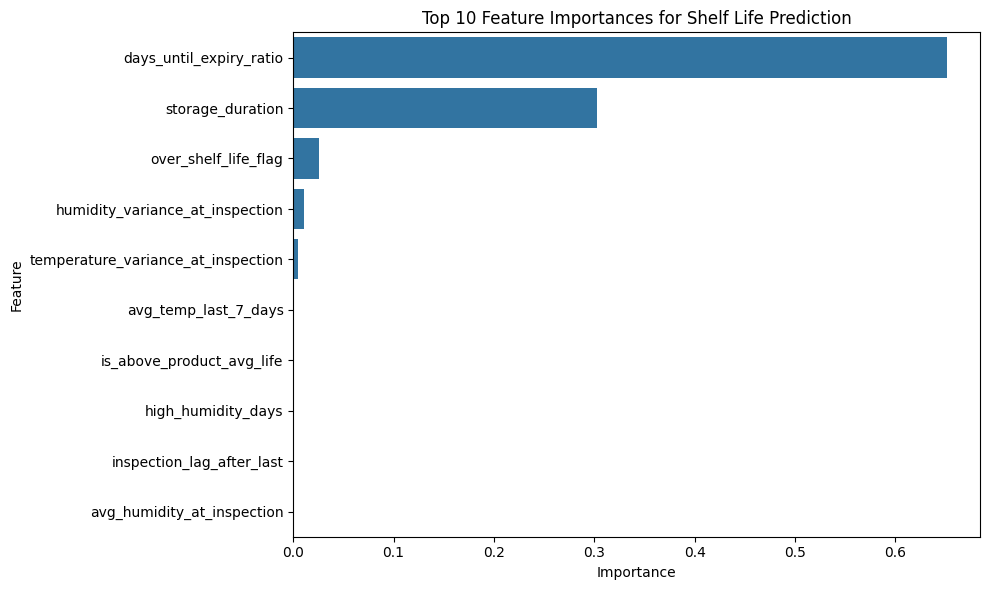

In [ ]:

print("\nFeature Importances (Top 10 Decision Tree):")
feature_importances = pd.Series(dt_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))

# Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances for Shelf Life Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()




Feature Importances (Top 10 from Random Forest):
days_until_expiry_ratio               0.680831
storage_duration                      0.284732
over_shelf_life_flag                  0.006898
storage_condition_score               0.006201
humidity_variance_at_inspection       0.004296
temperature_variance_at_inspection    0.003575
temp_humidity_volatility_score        0.003180
avg_temperature_at_inspection         0.002689
avg_humidity_at_inspection            0.002224
high_humidity_days                    0.001085
dtype: float64


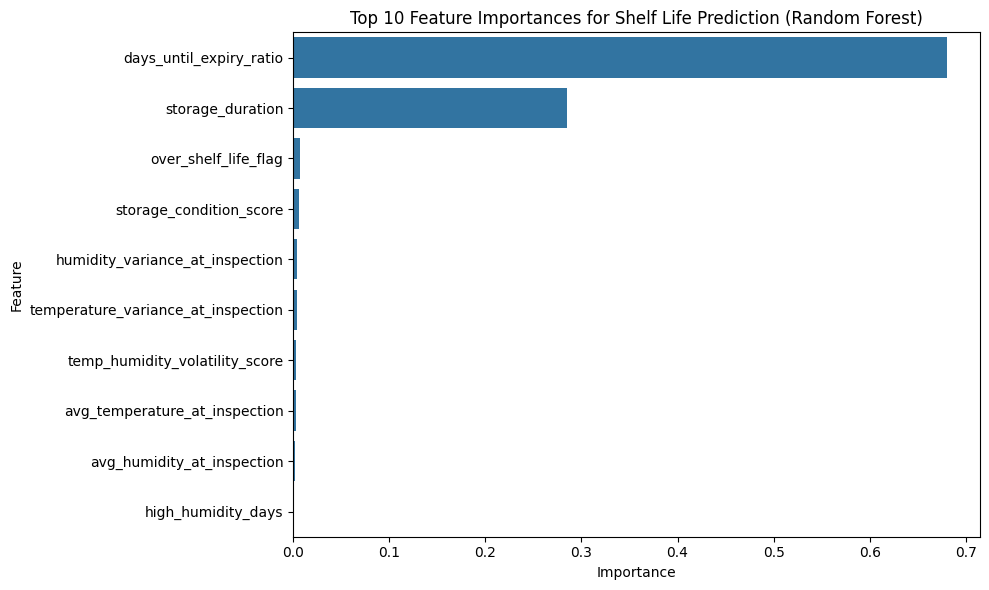

In [ ]:
# Feature Importance
print("\nFeature Importances (Top 10 from Random Forest):")
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))

# Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances for Shelf Life Prediction (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Feature Importances (Top 10 from LightGBM):
days_until_expiry_ratio               986
storage_duration                      904
temperature_variance_at_inspection    103
days_in_transit_ratio                 100
humidity_variance_at_inspection        93
avg_temperature_at_inspection          81
temp_deviation_from_ideal              70
days_since_last_inspection             62
temp_humidity_volatility_score         57
humidity_deviation_from_ideal          56
dtype: int32


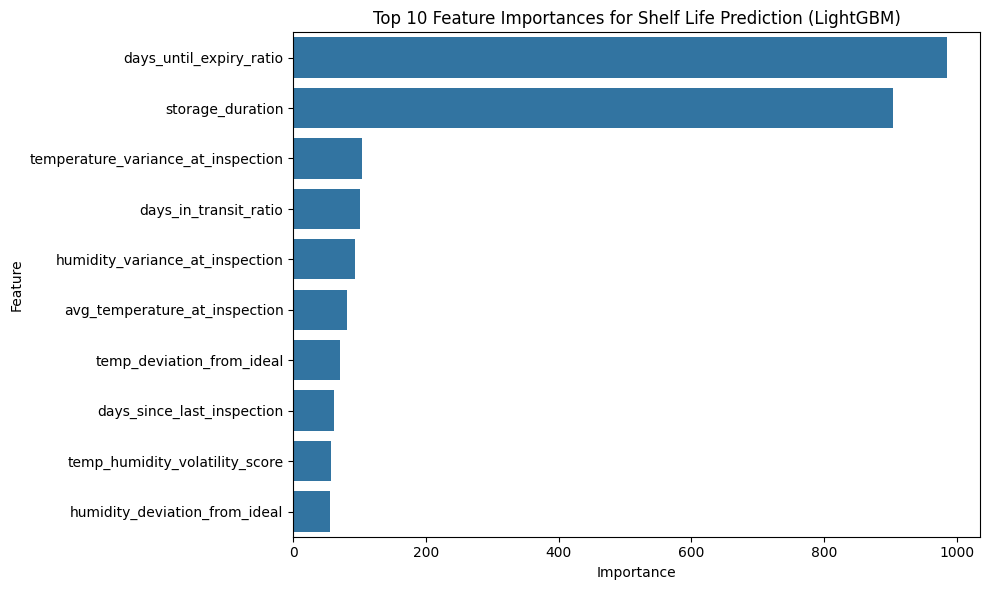

In [ ]:
# Feature Importance
print("\nFeature Importances (Top 10 from LightGBM):")
# LightGBM has different importance types, 'split' (default) counts times a feature is used in splits
# 'gain' sums the gain of splits where the feature is used
feature_importances = pd.Series(lgbm_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))

# LightGBM
# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances for Shelf Life Prediction (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Feature Importances (Top 10 from XGBoost):
days_until_expiry_ratio               0.334909
over_shelf_life_flag                  0.212856
storage_duration                      0.161579
temp_humidity_volatility_score        0.034229
is_above_product_avg_life             0.029666
temp_humidity_stress_score            0.024406
temperature_variance_at_inspection    0.019158
days_in_transit_ratio                 0.018769
batch_mean_utilization                0.018085
days_since_last_inspection            0.015702
dtype: float32


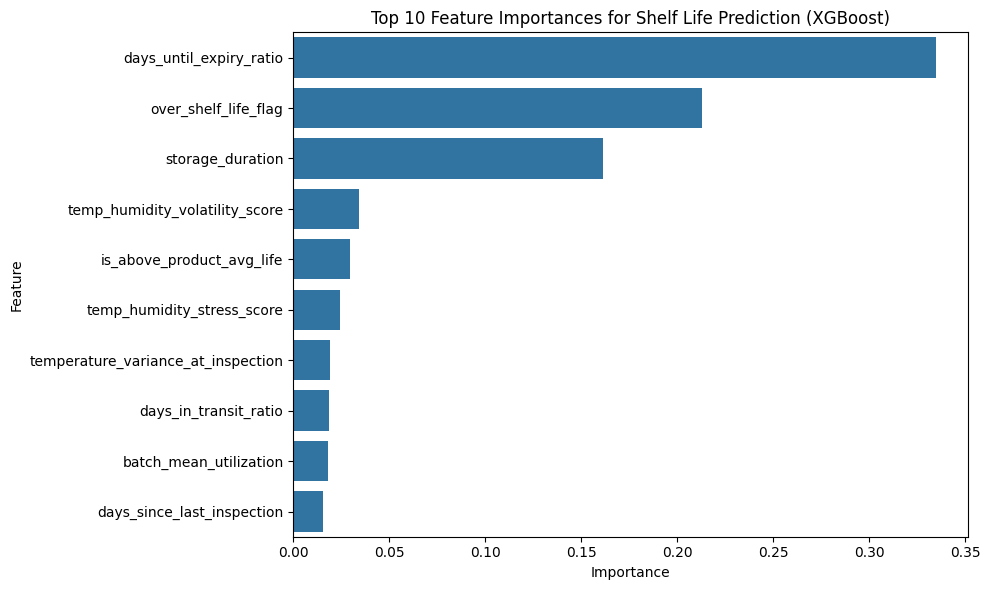

In [ ]:
# Feature Importance
print("\nFeature Importances (Top 10 from XGBoost):")
# XGBoost's feature_importances_ defaults to 'gain' type.
feature_importances = pd.Series(xgb_regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances for Shelf Life Prediction (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **SHAP Explanantions**

## **SHAP Explanations Decision Tree**


--- SHAP Explanations for Decision Tree---

SHAP Summary Plot (Overall Feature Impact):


/tmp/ipython-input-14-3755643121.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)


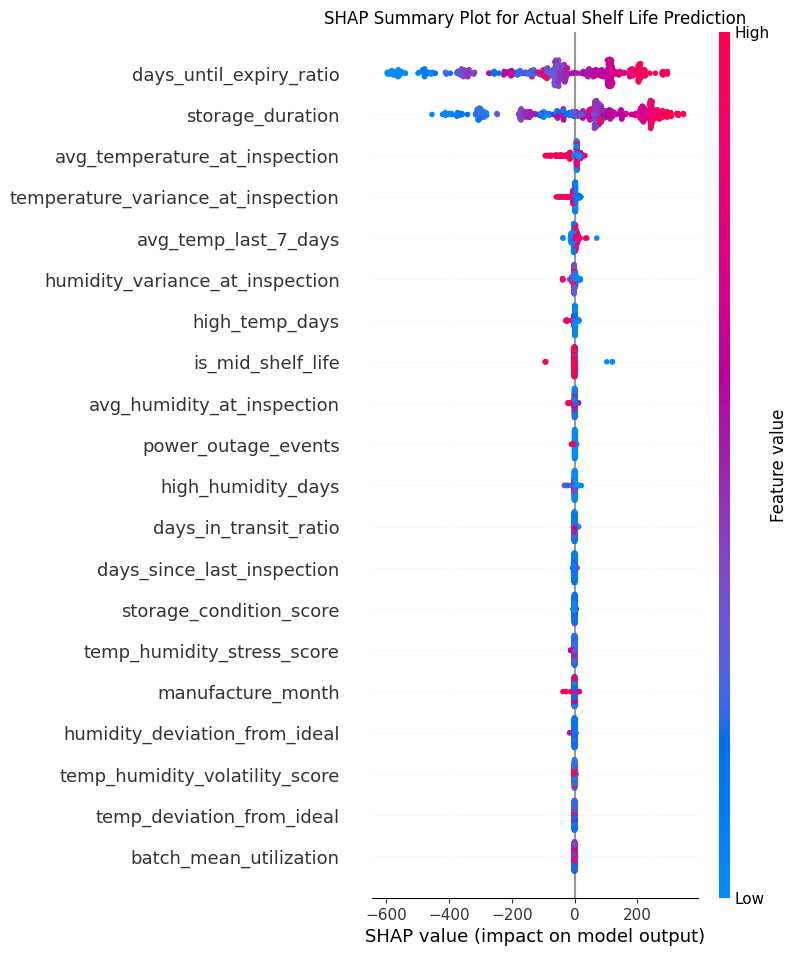

/tmp/ipython-input-14-3755643121.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)


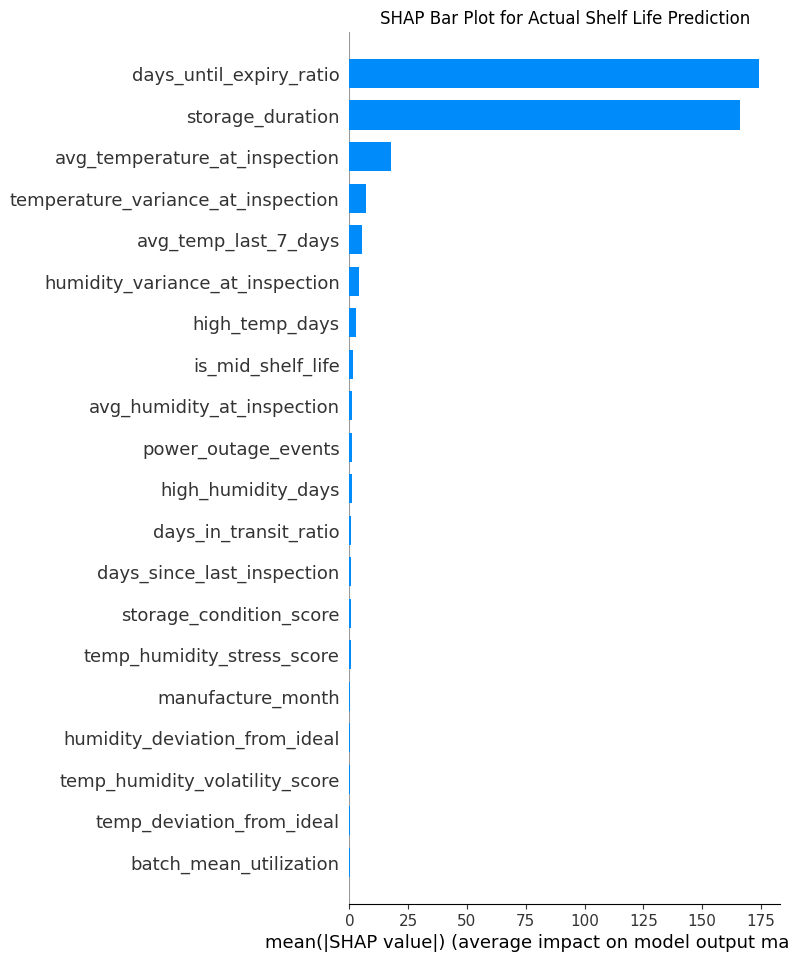

In [ ]:
# --- SHAP Explanations for Decision Tree ---

print("\n--- SHAP Explanations for Decision Tree---")

# Create a Tree explainer object
# The dt_regressor is a tree-based model, so TreeExplainer is efficient.
explainer = shap.TreeExplainer(dt_regressor)

# Calculate SHAP values for the test set
# X_test_display is used for plots, as shap sometimes wants original DataFrame for feature names
# We limit to a smaller subset of X_test for faster computation and clearer visualization
# (e.g., 100 or 500 samples, or the whole test set if it's not too big)
X_test_subset = X_test.sample(min(500, X_test.shape[0]), random_state=42) # Take max 500 samples or all if less
shap_values = explainer.shap_values(X_test_subset)

# 1. SHAP Summary Plot (Global Feature Importance and Impact)
print("\nSHAP Summary Plot (Overall Feature Impact):")
shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Summary Plot for Actual Shelf Life Prediction')
plt.show()

shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Bar Plot for Actual Shelf Life Prediction')
plt.show()


SHAP Dependence Plots (Feature Interactions):


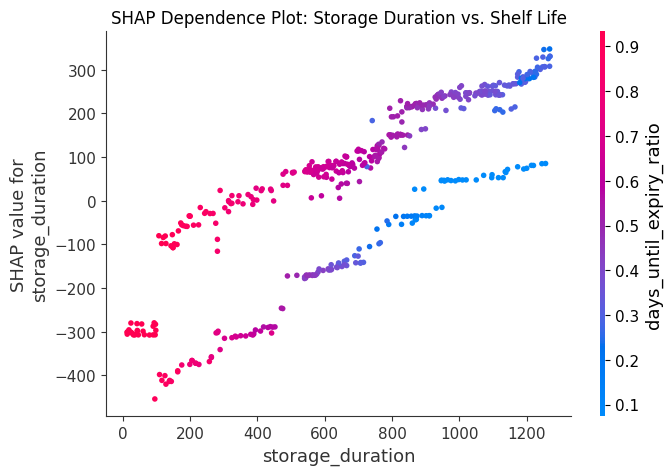

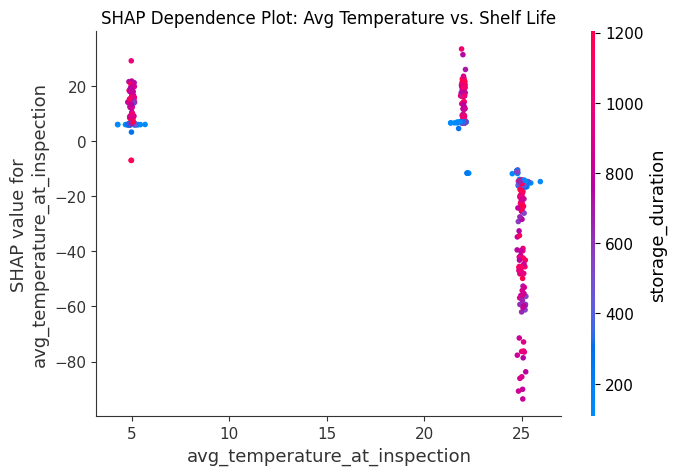

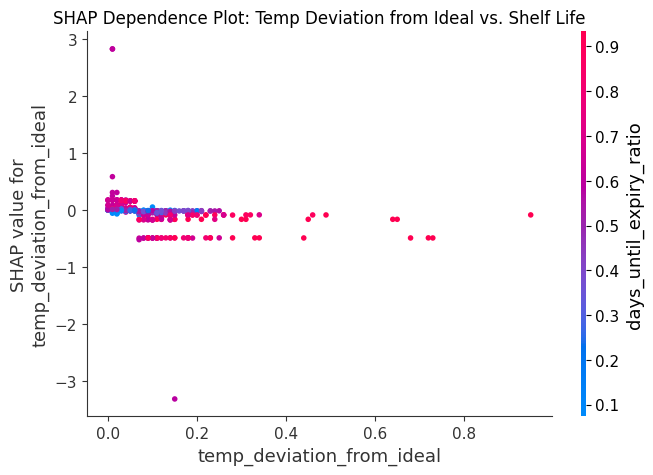

In [ ]:
# 2. SHAP Dependence Plots (Interaction between features - pick a few top features)
print("\nSHAP Dependence Plots (Feature Interactions):")
# Choose a couple of highly important features from the summary plot to investigate interactions
# Example: storage_duration, avg_temperature_at_inspection
# Note: You need to rerun the script to see what your *new* top features are after removals
# Let's pick a few common culprits or high-importance features, but adjust based on your actual output
if 'storage_duration' in features_for_model:
    shap.dependence_plot("storage_duration", shap_values, X_test_subset, show=False)
    plt.title('SHAP Dependence Plot: Storage Duration vs. Shelf Life')
    plt.show()
if 'avg_temperature_at_inspection' in features_for_model:
    shap.dependence_plot("avg_temperature_at_inspection", shap_values, X_test_subset, show=False)
    plt.title('SHAP Dependence Plot: Avg Temperature vs. Shelf Life')
    plt.show()
if 'temp_deviation_from_ideal' in features_for_model:
    shap.dependence_plot("temp_deviation_from_ideal", shap_values, X_test_subset, show=False)
    plt.title('SHAP Dependence Plot: Temp Deviation from Ideal vs. Shelf Life')
    plt.show()


SHAP Force Plot (Explanation for a Single Prediction):
Explaining prediction for test sample index 0


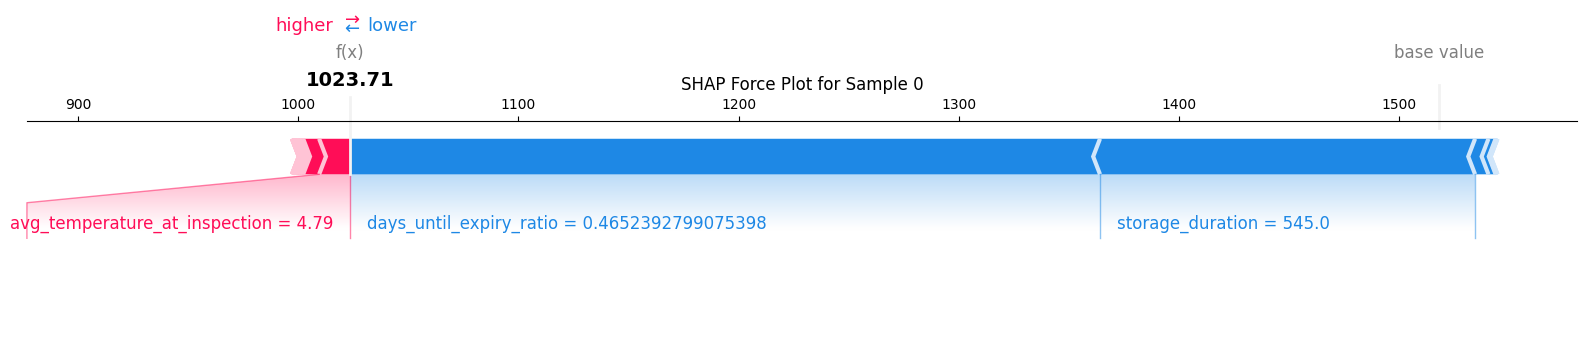

In [ ]:
# 3. SHAP Force Plot (Local Explanation for a Single Prediction)
print("\nSHAP Force Plot (Explanation for a Single Prediction):")
# Explain the first prediction in the test set (or any other index you choose)
sample_index = 0
print(f"Explaining prediction for test sample index {sample_index}")
shap.initjs() # For rendering the interactive plot in Jupyter notebooks/environments
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_subset.iloc[sample_index], show=False, matplotlib=True) # Use matplotlib=True for non-interactive output
plt.title(f'SHAP Force Plot for Sample {sample_index}')
plt.show()


## **SHAP Explanations for Random Forest**


--- SHAP Explanations for Random Forest ---

SHAP Summary Plot (Overall Feature Impact for Random Forest):


/tmp/ipython-input-17-587739167.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)


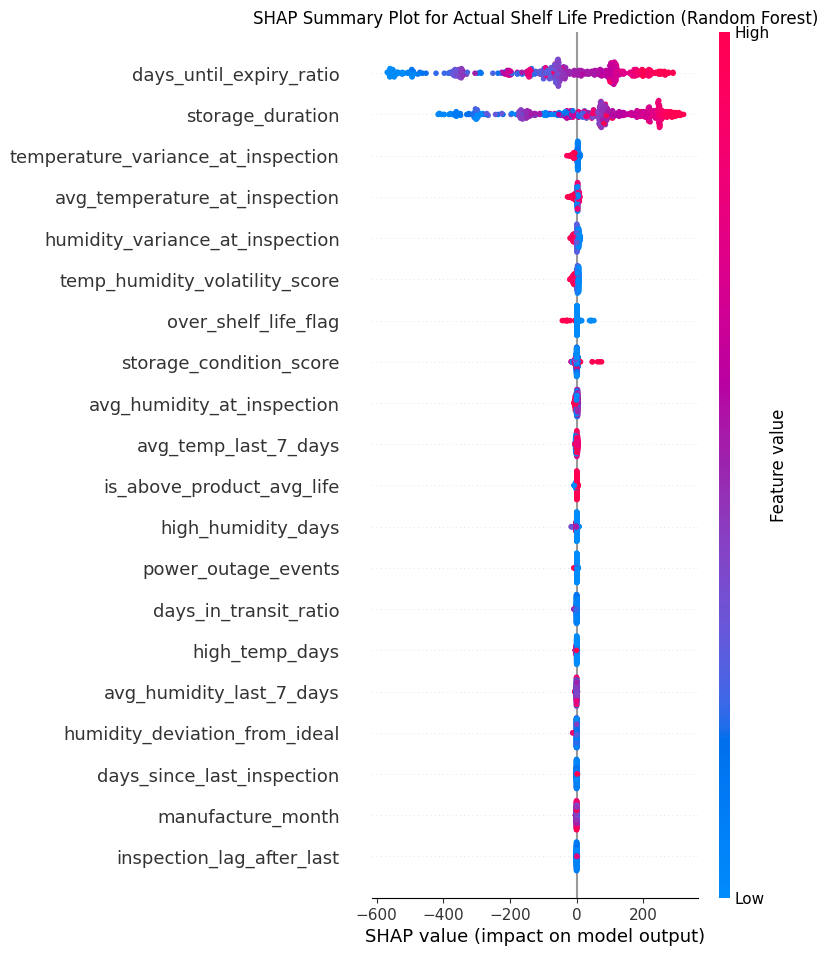

/tmp/ipython-input-17-587739167.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)


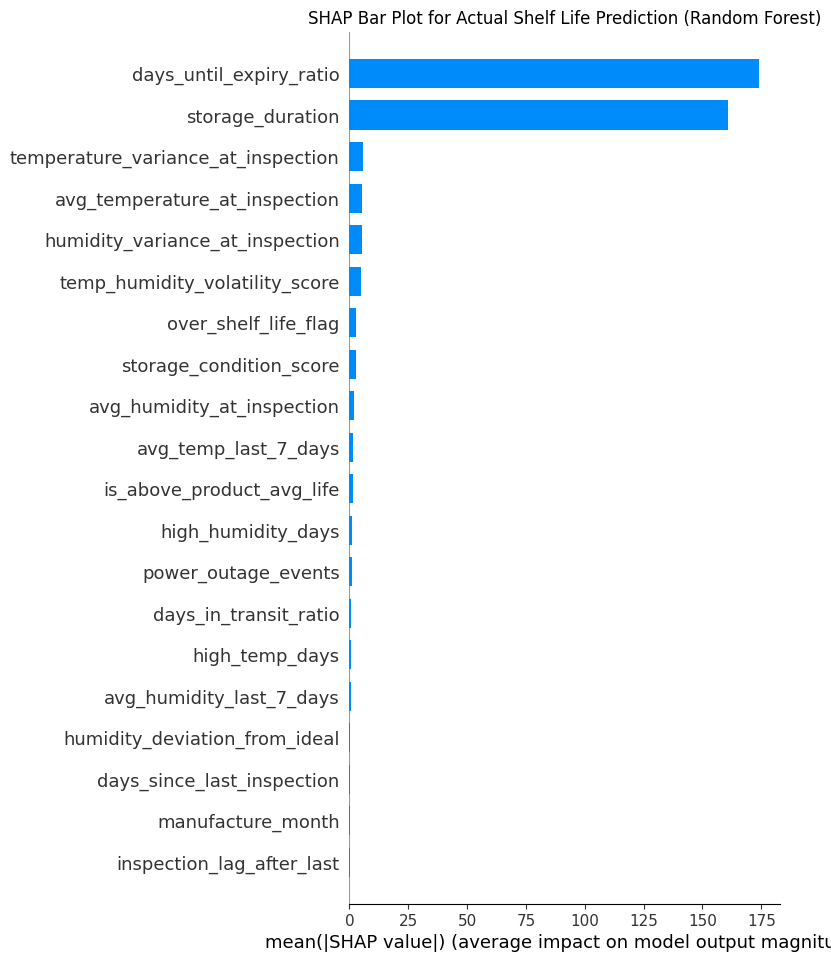

In [ ]:
# --- SHAP Explanations for Random Forest ---

print("\n--- SHAP Explanations for Random Forest ---")

# Create a Tree explainer object for the Random Forest model
explainer = shap.TreeExplainer(rf_regressor)

# Calculate SHAP values for a subset of the test set for faster computation and clearer visualization
X_test_subset = X_test.sample(min(500, X_test.shape[0]), random_state=42)
shap_values = explainer.shap_values(X_test_subset)

# 1. SHAP Summary Plot (Global Feature Importance and Impact)
print("\nSHAP Summary Plot (Overall Feature Impact for Random Forest):")
shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Summary Plot for Actual Shelf Life Prediction (Random Forest)')
plt.show()

shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Bar Plot for Actual Shelf Life Prediction (Random Forest)')
plt.show()




SHAP Dependence Plots (Feature Interactions for Random Forest):


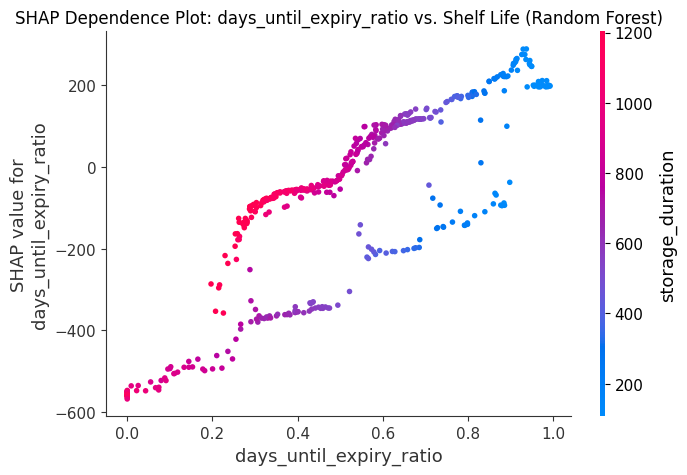

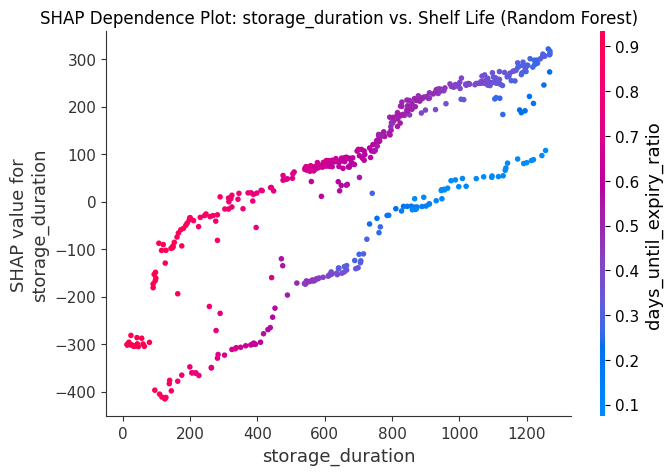

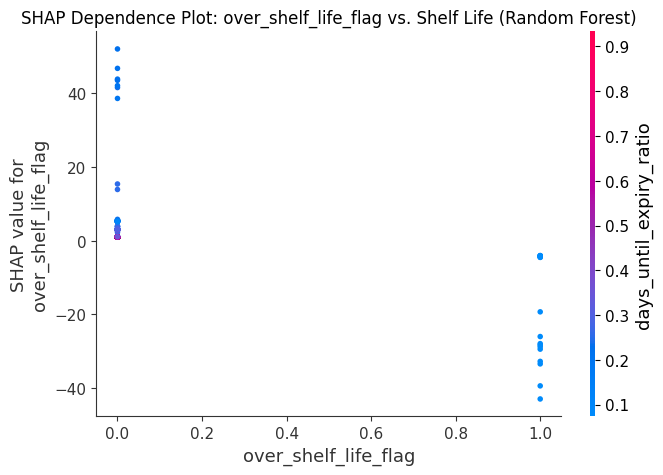

In [ ]:
# 2. SHAP Dependence Plots (Interaction between features - pick a few top features)
print("\nSHAP Dependence Plots (Feature Interactions for Random Forest):")
# Use the actual top features identified by the Random Forest model
top_features = feature_importances.head(3).index.tolist() # Get top 3 features for dependence plots

for feat in top_features:
    if feat in features_for_model:
        shap.dependence_plot(feat, shap_values, X_test_subset, show=False)
        plt.title(f'SHAP Dependence Plot: {feat} vs. Shelf Life (Random Forest)')
        plt.show()




SHAP Force Plot (Explanation for a Single Prediction from Random Forest):
Explaining prediction for test sample index 0


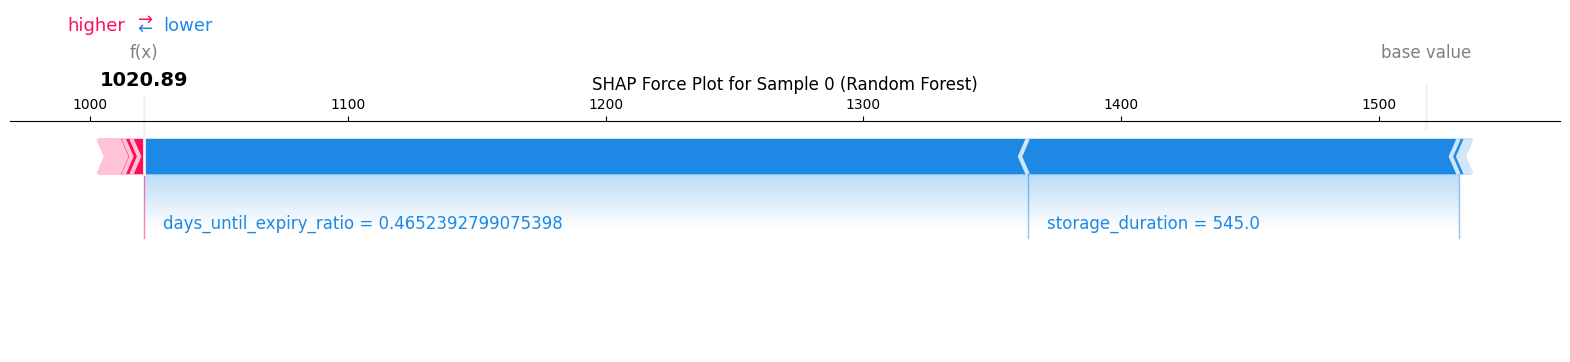

In [ ]:

# 3. SHAP Force Plot (Local Explanation for a Single Prediction)
print("\nSHAP Force Plot (Explanation for a Single Prediction from Random Forest):")
sample_index = 0
print(f"Explaining prediction for test sample index {sample_index}")
shap.initjs() # For rendering the interactive plot in Jupyter notebooks/environments
# Use matplotlib=True for non-interactive environments like this one
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_subset.iloc[sample_index], show=False, matplotlib=True)
plt.title(f'SHAP Force Plot for Sample {sample_index} (Random Forest)')
plt.show()

## **SHAP Explanations LightGBM**


--- SHAP Explanations for LightGBM ---

SHAP Summary Plot (Overall Feature Impact for LightGBM):


/tmp/ipython-input-10-4029068358.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)


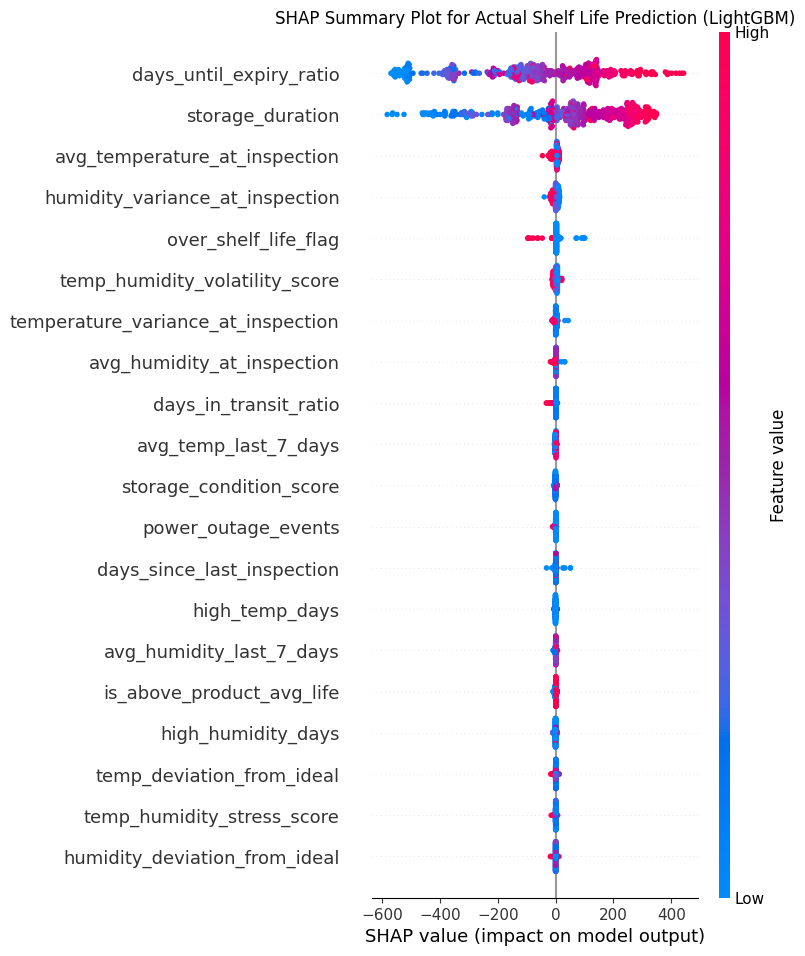

/tmp/ipython-input-10-4029068358.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)


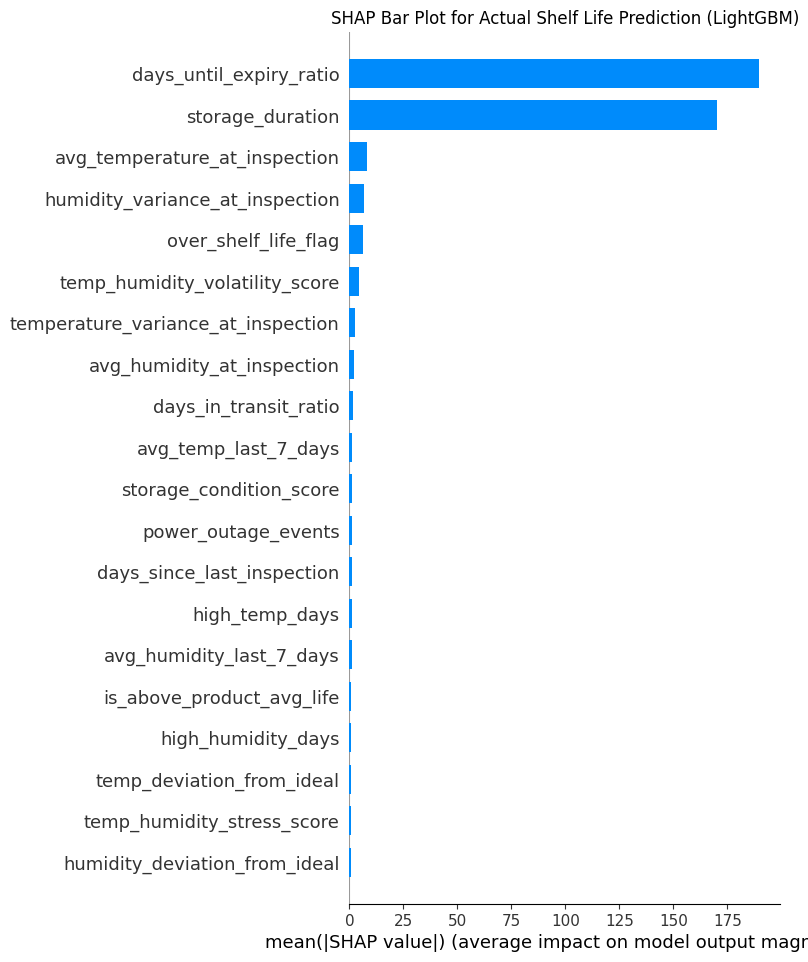

In [ ]:
# --- SHAP Explanations for LightGBM ---

print("\n--- SHAP Explanations for LightGBM ---")

# Create a Tree explainer object for the LightGBM model
explainer = shap.TreeExplainer(lgbm_regressor)

# Calculate SHAP values for a subset of the test set for faster computation and clearer visualization
X_test_subset = X_test.sample(min(500, X_test.shape[0]), random_state=42)
shap_values = explainer.shap_values(X_test_subset)

# 1. SHAP Summary Plot (Global Feature Importance and Impact)
print("\nSHAP Summary Plot (Overall Feature Impact for LightGBM):")
shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Summary Plot for Actual Shelf Life Prediction (LightGBM)')
plt.show()

shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Bar Plot for Actual Shelf Life Prediction (LightGBM)')
plt.show()


SHAP Dependence Plots (Feature Interactions for LightGBM):


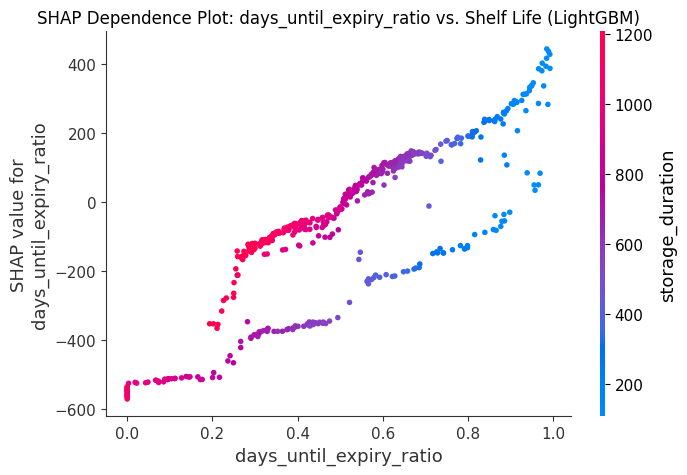

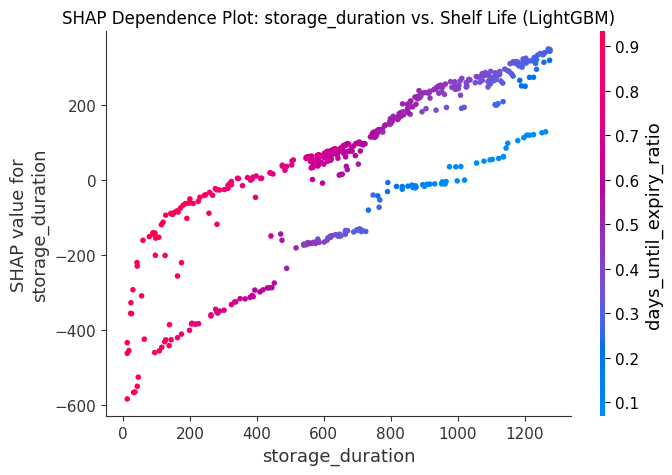

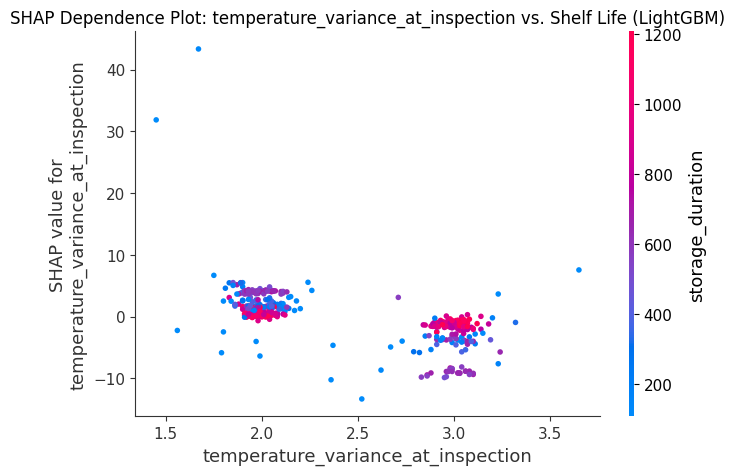

In [ ]:
# 2. SHAP Dependence Plots (Interaction between features - pick a few top features)
print("\nSHAP Dependence Plots (Feature Interactions for LightGBM):")
# Use the actual top features identified by the LightGBM model
top_features = feature_importances.head(3).index.tolist() # Get top 3 features for dependence plots

for feat in top_features:
    if feat in features_for_model:
        shap.dependence_plot(feat, shap_values, X_test_subset, show=False)
        plt.title(f'SHAP Dependence Plot: {feat} vs. Shelf Life (LightGBM)')
        plt.show()


SHAP Force Plot (Explanation for a Single Prediction from LightGBM):
Explaining prediction for test sample index 0


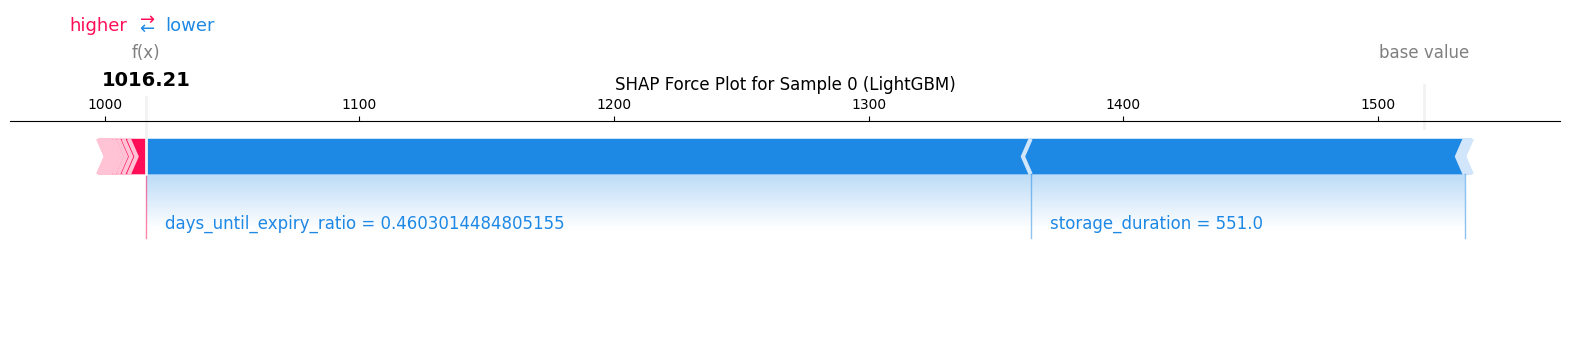

In [ ]:
# 3. SHAP Force Plot (Local Explanation for a Single Prediction)
print("\nSHAP Force Plot (Explanation for a Single Prediction from LightGBM):")
sample_index = 0
print(f"Explaining prediction for test sample index {sample_index}")
shap.initjs() # For rendering the interactive plot in Jupyter notebooks/environments
# Use matplotlib=True for non-interactive environments like this one
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_subset.iloc[sample_index], show=False, matplotlib=True)
plt.title(f'SHAP Force Plot for Sample {sample_index} (LightGBM)')
plt.show()

## **SHAP Explanations XGBoost**


--- SHAP Explanations for XGBoost ---

SHAP Summary Plot (Overall Feature Impact for XGBoost):


/tmp/ipython-input-26-3292697877.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)


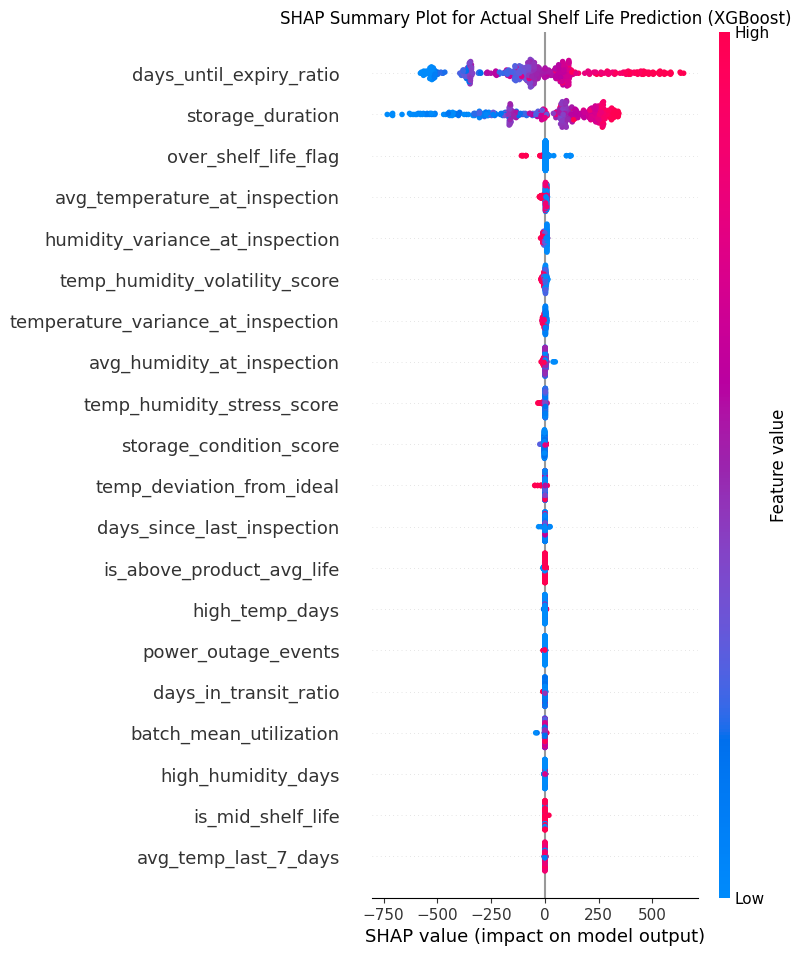

/tmp/ipython-input-26-3292697877.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)


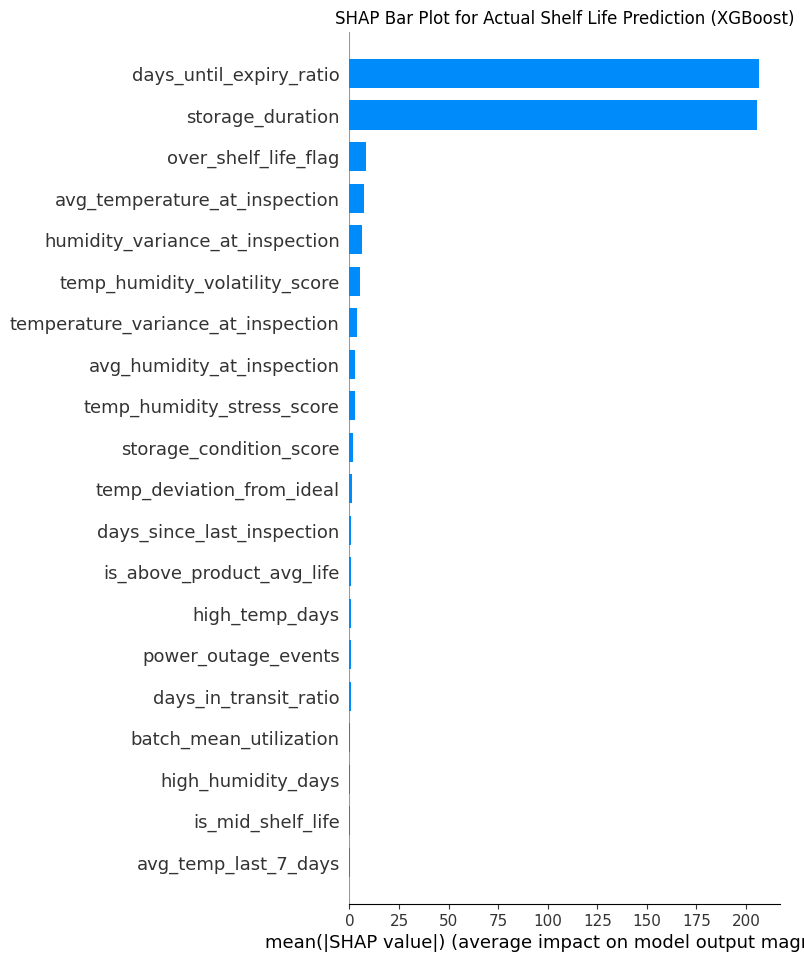

In [ ]:
# --- SHAP Explanations for XGBoost ---

print("\n--- SHAP Explanations for XGBoost ---")

# Create a Tree explainer object for the XGBoost model
explainer = shap.TreeExplainer(xgb_regressor)

# Calculate SHAP values for a subset of the test set for faster computation and clearer visualization
X_test_subset = X_test.sample(min(500, X_test.shape[0]), random_state=42)
shap_values = explainer.shap_values(X_test_subset)

# 1. SHAP Summary Plot (Global Feature Importance and Impact)
print("\nSHAP Summary Plot (Overall Feature Impact for XGBoost):")
shap.summary_plot(shap_values, X_test_subset, plot_type="dot", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Summary Plot for Actual Shelf Life Prediction (XGBoost)')
plt.show()

shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X_test_subset.columns, show=False)
plt.title('SHAP Bar Plot for Actual Shelf Life Prediction (XGBoost)')
plt.show()


SHAP Dependence Plots (Feature Interactions for XGBoost):


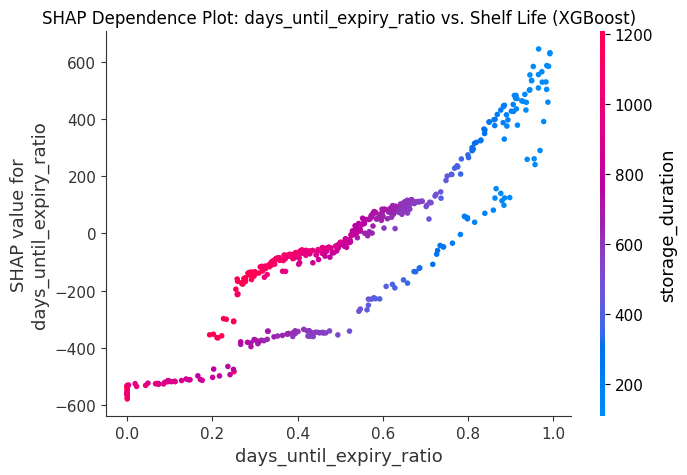

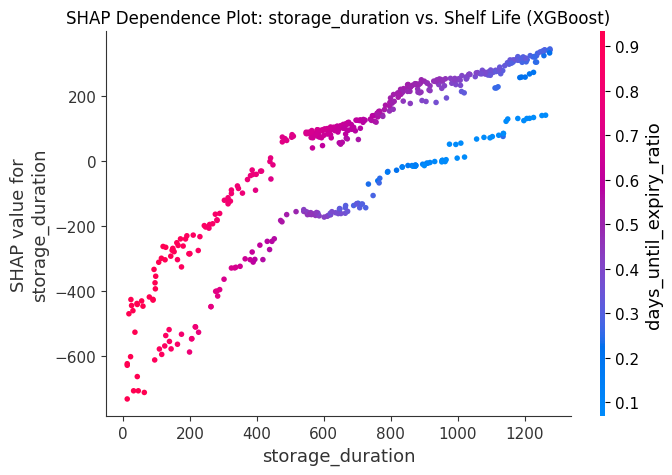

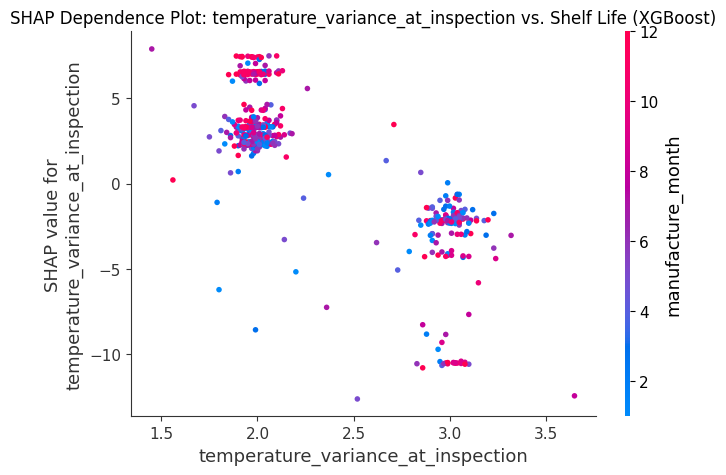

In [ ]:
# 2. SHAP Dependence Plots (Interaction between features - pick a few top features)
print("\nSHAP Dependence Plots (Feature Interactions for XGBoost):")
# Use the actual top features identified by the XGBoost model
top_features = feature_importances.head(3).index.tolist() # Get top 3 features for dependence plots

for feat in top_features:
    if feat in features_for_model:
        shap.dependence_plot(feat, shap_values, X_test_subset, show=False)
        plt.title(f'SHAP Dependence Plot: {feat} vs. Shelf Life (XGBoost)')
        plt.show()


SHAP Force Plot (Explanation for a Single Prediction from XGBoost):
Explaining prediction for test sample index 0


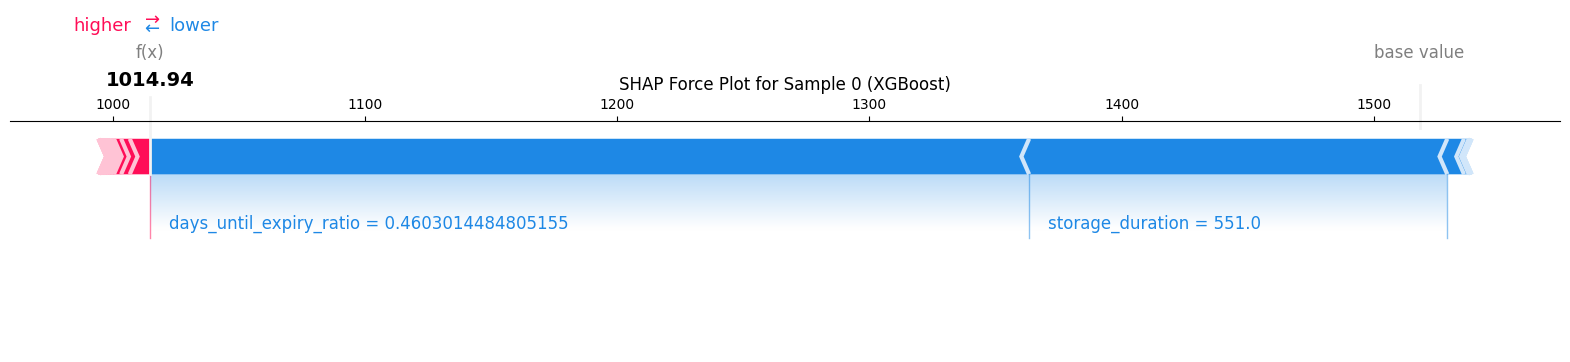

In [ ]:
# 3. SHAP Force Plot (Local Explanation for a Single Prediction)
print("\nSHAP Force Plot (Explanation for a Single Prediction from XGBoost):")
sample_index = 0
print(f"Explaining prediction for test sample index {sample_index}")
shap.initjs() # For rendering the interactive plot in Jupyter notebooks/environments
# Use matplotlib=True for non-interactive environments like this one
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_subset.iloc[sample_index], show=False, matplotlib=True)
plt.title(f'SHAP Force Plot for Sample {sample_index} (XGBoost)')
plt.show()

## **Visualizing the Decision Tree**

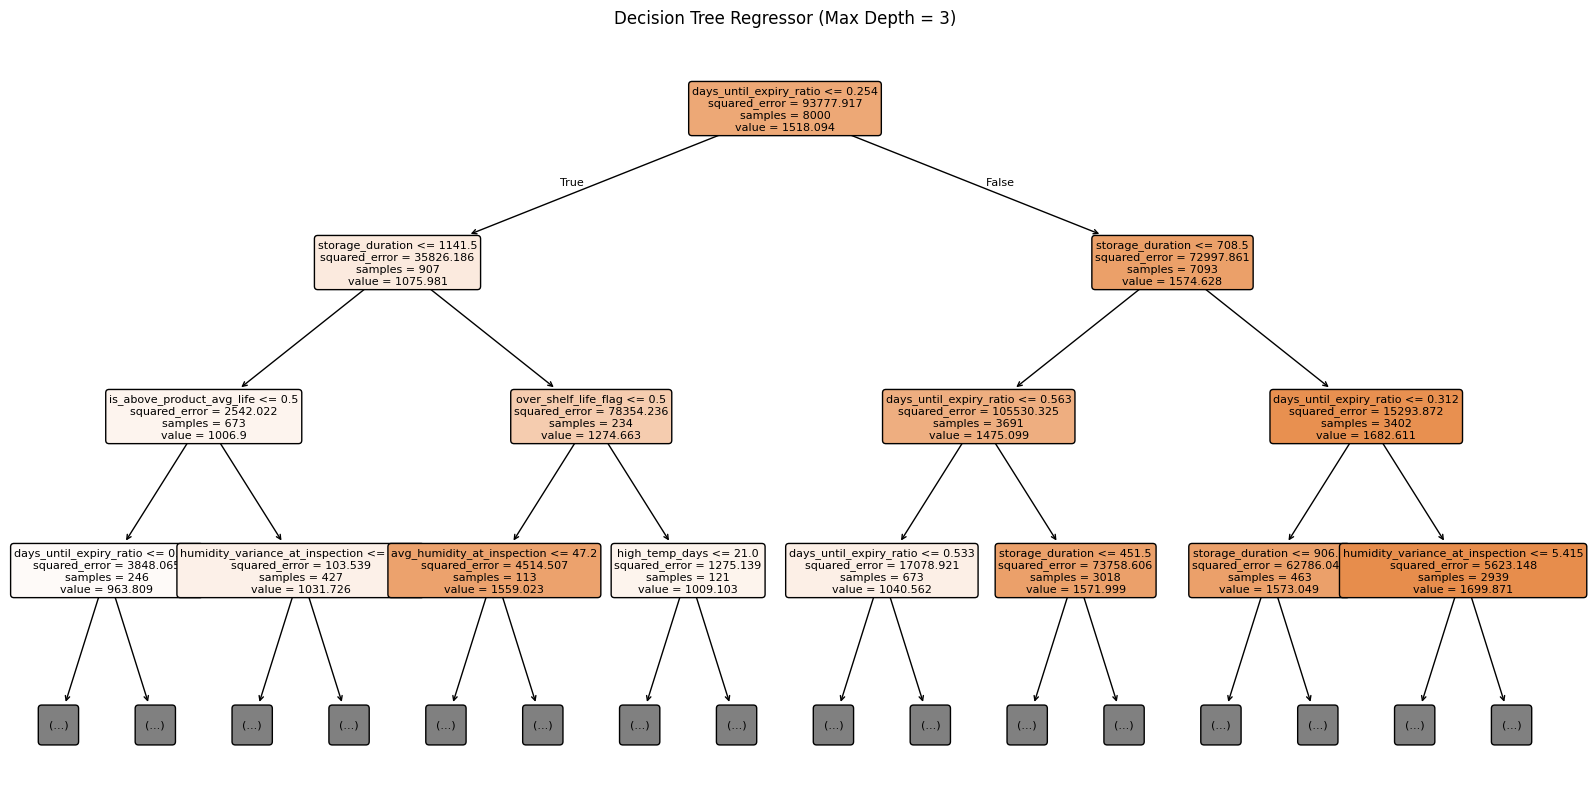

In [ ]:
# Visualizing the Decision Tree (for a smaller max_depth to make it readable)
# adjust max_depth and other hyperparameters for optimal performance and interpretability
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor,
          feature_names=X.columns.tolist(),
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=3 # Visualize only the top layers for clarity
         )
plt.title('Decision Tree Regressor (Max Depth = 3)')
plt.show()